# Telecom Churn Prediction Case Study

**Author:** Abhishek Mukherjee , Vaibhav Singh Chauhan

# Content
- Problem Statement
- Loading Datasets and Libraries
- Create X, y and then Train test split
- Handling Missing Value and Duplicated data
- Exploratory Data Analysis & Preprocessing
- Feature Engineering and Selection
- Model Building and Baselining
- Model evaluation, Selection and Prediction

# 0. Problem statement

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

For many incumbent operators, retaining high profitable customers is the number one business
goal. To reduce customer churn, telecom companies need to predict which customers are at high risk of churn. In this project, we are expected analyze customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn, and identify the main indicators of churn.

In this competition, our goal is *to build a machine learning model that is able to predict churning customers based on the features provided for their usage.*



# 1. Loading Datasets and Libraries

Lets start by loading required libraries. We can keep adding any imports to this cell block, as we write mode and mode code.

In [1]:
#Data Structures
import pandas as pd
import numpy as np
import re
import os

#pip install missingno
import missingno as msno

# For MICE Imputation
#!pip install fancyimpute
from fancyimpute import IterativeImputer

#Sklearn
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report

# Class Imbalance handling
from imblearn.over_sampling import SMOTE

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

#Others
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Next, we load our datasets and the data dictionary file.

The **train.csv** file contains both dependent and independent features, while the **test.csv** contains only the independent variables. 

So, for model selection, we will create our own train/test dataset from the **train.csv** and use the model to predict the solution using the features in unseen test.csv data for submission.

In [2]:
data = pd.read_csv("train.csv")
unseen = pd.read_csv("test.csv")
sample = pd.read_csv("sample.csv")
data_dict = pd.read_csv("data_dictionary.csv")

print(data.shape)
print(unseen.shape)
print(sample.shape)
print(data_dict.shape)

(69999, 172)
(30000, 171)
(30000, 2)
(36, 2)


1. Lets analyze the data dictionary versus the churn dataset.
2. The data dictonary contains a list of abbrevations which provide you all the information you need to understand what a specific feature/variable in the churn dataset represents
3. Example: 

> "arpu_7" -> Average revenue per user + KPI for the month of July
>
> "onnet_mou_6" ->  All kind of calls within the same operator network + Minutes of usage voice calls + KPI for the month of June
>
>"night_pck_user_8" -> Scheme to use during specific night hours only + Prepaid service schemes called PACKS + KPI for the month of August
>
>"max_rech_data_7" -> Maximum + Recharge + Mobile internet + KPI for the month of July

Its important to understand the definitions of each feature that we are working with, which will help in analyzing which features might impact the churn rate of a user, and what sort of analysis could be done to understand the distribution of the feature better.

In [3]:
data_dict

Acronyms                                        Description
0     CIRCLE_ID  Telecom circle area to which the customer belo...
1           LOC            Local calls  within same telecom circle
2           STD              STD calls  outside the calling circle
3            IC                                     Incoming calls
4            OG                                     Outgoing calls
5           T2T  Operator T to T ie within same operator mobile...
6       T2M                    Operator T to other operator mobile
7       T2O                Operator T to other operator fixed line
8       T2F                         Operator T to fixed lines of T
9       T2C                      Operator T to its own call center
10     ARPU                               Average revenue per user
11      MOU                          Minutes of usage  voice calls
12      AON      Age on network  number of days the customer is...
13     ONNET     All kind of calls within the same operator net...
14   OFFNET       All kind of calls outside the operator T network
15         ROAM  Indicates that customer is in roaming zone dur...
16       SPL                                         Special calls
17      ISD                                              ISD calls
18     RECH                                               Recharge
19      NUM                                                 Number
20      AMT                               Amount in local currency
21      MAX                                                Maximum
22     DATA                                        Mobile internet
23       3G                                              G network
24       AV                                                Average
25      VOL                     Mobile internet usage volume in MB
26       2G                                              G network
27      PCK                  Prepaid service schemes called  PACKS
28    NIGHT         Scheme to use during specific night hours only
29  MONTHLY      Service schemes with validity equivalent to a ...
30    SACHET     Service schemes with validity smaller than a m...
31      *.6                              KPI for the month of June
32      *.7                              KPI for the month of July
33      *.8                            KPI for the month of August
34      FB_USER  Service scheme to avail services of Facebook a...
35      VBC      Volume based cost  when no specific scheme is ...

In [4]:
# Setting the maximum columns and rows display
pd.set_option("display.max_columns",300)
pd.set_option("display.max_rows",500)

In [5]:
# Lets see the train data
data.head() 

id  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0   0        109             0.0             0.0             0.0   
1   1        109             0.0             0.0             0.0   
2   2        109             0.0             0.0             0.0   
3   3        109             0.0             0.0             0.0   
4   4        109             0.0             0.0             0.0   

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
0            6/30/2014            7/31/2014            8/31/2014   31.277   
1            6/30/2014            7/31/2014            8/31/2014    0.000   
2            6/30/2014            7/31/2014            8/31/2014   60.806   
3            6/30/2014            7/31/2014            8/31/2014  156.362   
4            6/30/2014            7/31/2014            8/31/2014  240.708   

    arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
0   87.009    7.527        48.58       124.38         1.29         32.24   
1  122.787   42.953         0.00         0.00         0.00          0.00   
2  103.176    0.000         0.53        15.93         0.00         53.99   
3  205.260  111.095         7.26        16.01         0.00         68.76   
4  128.191  101.565        21.28         4.83         6.13         56.99   

   offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0         96.68          2.33           0.00            0.0            0.0   
1         25.99         30.89           0.00            0.0            0.0   
2         82.05          0.00           0.00            0.0            0.0   
3         78.48         50.23           0.00            0.0            0.0   
4         38.11          9.63          53.64            0.0            0.0   

   roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
0           0.00            0.0           0.00              2.23   
1           0.00            0.0           0.00              0.00   
2           0.00            0.0           0.00              0.53   
3           0.00            0.0           1.63              6.99   
4          15.73            0.0           0.00             10.16   

   loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
0              0.00              0.28              5.29             16.04   
1              0.00              0.00              0.00              0.00   
2             12.98              0.00             24.11              0.00   
3              3.94              0.00             37.91             44.89   
4              4.83              6.13             36.74             19.88   

   loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
0              2.33              0.00              0.00              0.00   
1              0.00              0.00              0.00              0.00   
2              0.00              0.00              0.00              0.00   
3             23.63              0.00              0.00              0.00   
4              4.61             11.99              1.23              5.01   

   loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
0              0.00              0.00              0.00          7.53   
1              0.00             22.01             29.79          0.00   
2              2.14              0.00              0.00         24.64   
3              0.00              0.00              8.03         44.91   
4              0.00              9.85              0.00         58.91   

   loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  std_og_t2t_mou_7  \
0         16.04          2.61             46.34            124.38   
1          0.00          0.00              0.00              0.00   
2         12.98          0.00              0.00              2.94   
3         48.84         23.63              0.26             12.06   
4         25.94         15.76              0.00              0.00   

   std_og_t2t_mo

In [6]:
# Set index as id
data = data.set_index('id')
data.head()

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
id                                                              
0         109             0.0             0.0             0.0   
1         109             0.0             0.0             0.0   
2         109             0.0             0.0             0.0   
3         109             0.0             0.0             0.0   
4         109             0.0             0.0             0.0   

   last_date_of_month_6 last_date_of_month_7 last_date_of_month_8   arpu_6  \
id                                                                           
0             6/30/2014            7/31/2014            8/31/2014   31.277   
1             6/30/2014            7/31/2014            8/31/2014    0.000   
2             6/30/2014            7/31/2014            8/31/2014   60.806   
3             6/30/2014            7/31/2014            8/31/2014  156.362   
4             6/30/2014            7/31/2014            8/31/2014  240.708   

     arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  \
id                                                                          
0    87.009    7.527        48.58       124.38         1.29         32.24   
1   122.787   42.953         0.00         0.00         0.00          0.00   
2   103.176    0.000         0.53        15.93         0.00         53.99   
3   205.260  111.095         7.26        16.01         0.00         68.76   
4   128.191  101.565        21.28         4.83         6.13         56.99   

    offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                            
0          96.68          2.33           0.00            0.0            0.0   
1          25.99         30.89           0.00            0.0            0.0   
2          82.05          0.00           0.00            0.0            0.0   
3          78.48         50.23           0.00            0.0            0.0   
4          38.11          9.63          53.64            0.0            0.0   

    roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                  
0            0.00            0.0           0.00              2.23   
1            0.00            0.0           0.00              0.00   
2            0.00            0.0           0.00              0.53   
3            0.00            0.0           1.63              6.99   
4           15.73            0.0           0.00             10.16   

    loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                           
0               0.00              0.28              5.29             16.04   
1               0.00              0.00              0.00              0.00   
2              12.98              0.00             24.11              0.00   
3               3.94              0.00             37.91             44.89   
4               4.83              6.13             36.74             19.88   

    loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                           
0               2.33              0.00              0.00              0.00   
1               0.00              0.00              0.00              0.00   
2               0.00              0.00              0.00              0.00   
3              23.63              0.00              0.00              0.00   
4               4.61             11.99              1.23              5.01   

    loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                       
0               0.00              0.00              0.00          7.53   
1               0.00             22.01             29.79          0.00   
2               2.14             

In [7]:
# Lets get information on the dataset
data.info(verbose=1)

<class 'pandas.core.frame.DataFrame'>
Index: 69999 entries, 0 to 69998
Data columns (total 171 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    circle_id                 int64  
 1    loc_og_t2o_mou            float64
 2    std_og_t2o_mou            float64
 3    loc_ic_t2o_mou            float64
 4    last_date_of_month_6      object 
 5    last_date_of_month_7      object 
 6    last_date_of_month_8      object 
 7    arpu_6                    float64
 8    arpu_7                    float64
 9    arpu_8                    float64
 10   onnet_mou_6               float64
 11   onnet_mou_7               float64
 12   onnet_mou_8               float64
 13   offnet_mou_6              float64
 14   offnet_mou_7              float64
 15   offnet_mou_8              float64
 16   roam_ic_mou_6             float64
 17   roam_ic_mou_7             float64
 18   roam_ic_mou_8             float64
 19   roam_og_mou_6             float64
 20   roam_og_m

In [8]:
# Lets get some summary statistics with some basic outliers analysis
# Including data at various percentiles as well
data.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
count    69999.0         69297.0         69297.0         69297.0   
mean       109.0             0.0             0.0             0.0   
std          0.0             0.0             0.0             0.0   
min        109.0             0.0             0.0             0.0   
25%        109.0             0.0             0.0             0.0   
50%        109.0             0.0             0.0             0.0   
75%        109.0             0.0             0.0             0.0   
90%        109.0             0.0             0.0             0.0   
95%        109.0             0.0             0.0             0.0   
99%        109.0             0.0             0.0             0.0   
max        109.0             0.0             0.0             0.0   

             arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  69999.000000  69999.000000  69999.000000  67231.000000  67312.000000   
mean     283.134365    278.185912    278.858826    133.153275    133.894438   
std      334.213918    344.366927    351.924315    299.963093    311.277193   
min    -2258.709000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.581000     86.714000     84.095000      7.410000      6.675000   
50%      197.484000    191.588000    192.234000     34.110000     32.280000   
75%      370.791000    365.369500    369.909000    119.390000    115.837500   
90%      619.993800    615.661400    614.994600    345.080000    347.908000   
95%      832.022700    823.236700    828.464700    617.185000    628.437500   
99%     1400.276640   1414.891380   1445.054800   1447.098000   1478.540900   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  66296.000000  67231.000000  67312.000000  66296.000000   67231.000000   
mean     132.978257    198.874771    197.153383    196.543577       9.765435   
std      311.896596    316.818355    322.482226    324.089234      57.374429   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        6.410000     34.860000     32.240000     31.575000       0.000000   
50%       32.100000     96.480000     91.885000     91.800000       0.000000   
75%      115.060000    232.990000    227.630000    229.345000       0.000000   
90%      343.695000    482.030000    482.071000    486.980000      11.950000   
95%      620.240000    735.985000    747.558000    738.017500      41.350000   
99%     1472.480500   1546.471000   1545.104000   1522.474000     219.649000   
max    10752.560000   8362.360000   7043.980000  14007.340000    2850.980000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   67312.000000   66296.000000   67231.000000   67312.000000   
mean        7.014568       7.004892      14.186457       9.842191   
std        55.960985      53.408135      73.469261      58.511894   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         5.039000       5.210000      22.710000       9.900000   
95%        23.199000      23.990000      69.455000      42.599000   
99%       153.006700     159.714000     290.851000     221.866800   
max      4155.830000    4169.810000    3775.110000    2812.040000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   66296.000000      67231.000000      67312.000000      66296.000000   
mean        9.771783         46.904854         46.166503         45.686109   
std        64.618388        150.971758        154.739002        153.716880   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.660000          1.650000     

There seems to be outliers in the numerical data, so we need to remove them for model building stage (some models may be influenced by outliers and we don't want that to happen)

# 2. Create X, y and then Train test split

Lets create X and y datasets and skip "circle_id" since it has only 1 unique value

In [9]:
data['circle_id'].unique()

array([109])

In [10]:
# Create the X, y data

X = data.drop(['circle_id'], axis=1).iloc[:,:-1]
y = data.iloc[:,-1]

X.shape, y.shape

((69999, 169), (69999,))

**Splitting train and test data to avoid any contamination of the test data**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((55999, 169), (14000, 169), (55999,), (14000,))

In [12]:
X_train.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
38586             0.0             0.0             0.0            6/30/2014   
4799              0.0             0.0             0.0            6/30/2014   
25257             0.0             0.0             0.0            6/30/2014   
44059             0.0             0.0             0.0            6/30/2014   
29081             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  \
id                                                                           
38586            7/31/2014            8/31/2014   18.080  200.118    7.720   
4799             7/31/2014            8/31/2014  253.987  334.951  712.723   
25257            7/31/2014            8/31/2014  206.348  297.970  401.941   
44059            7/31/2014            8/31/2014   80.141  107.471   82.996   
29081            7/31/2014            8/31/2014  192.482  178.162  145.594   

       onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
38586         0.00        31.04         6.95         18.83        144.96   
4799        366.56       605.61      1539.81        102.24        114.98   
25257        31.34        37.09        72.01        209.36        195.33   
44059        35.89        44.78        55.79         65.09         84.66   
29081        55.38        79.03        86.21        152.84        128.13   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
38586          1.09            0.0            0.0            0.0   
4799         208.24            0.0            0.0            0.0   
25257        231.66            0.0            0.0            0.0   
44059         51.04            0.0            0.0            0.0   
29081         76.98            0.0            0.0            0.0   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
38586            0.0            0.0            0.0              0.00   
4799             0.0            0.0            0.0              1.68   
25257            0.0            0.0            0.0             16.68   
44059            0.0            0.0            0.0             35.89   
29081            0.0            0.0            0.0             55.38   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
38586             31.04              6.95             18.83            143.91   
4799               8.23             12.46             11.11             26.79   
25257              0.00              5.23             96.59            124.56   
44059             44.78             55.79             64.91             84.66   
29081             38.69             85.28            148.26            120.53   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                              
38586              1.09              0.00              1.05              0.00   
4799              17.71              0.00              0.00              0.00   
25257            133.83              2.05              3.26              4.64   
44059             51.04              0.00              0.00              0.00   
29081             72.26              3.98              7.59              1.83   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                          
38586              0.00               0.0              0.00         18.83   
4799               0.00        

# 3. Handling Missing & Duplicate Data

We will be imputing missing data approach only in X_train dataset and the imputed values learned from X_train dataset will be later applied to X_test dataset. This is an approach to help avoid contamination

<Axes: >

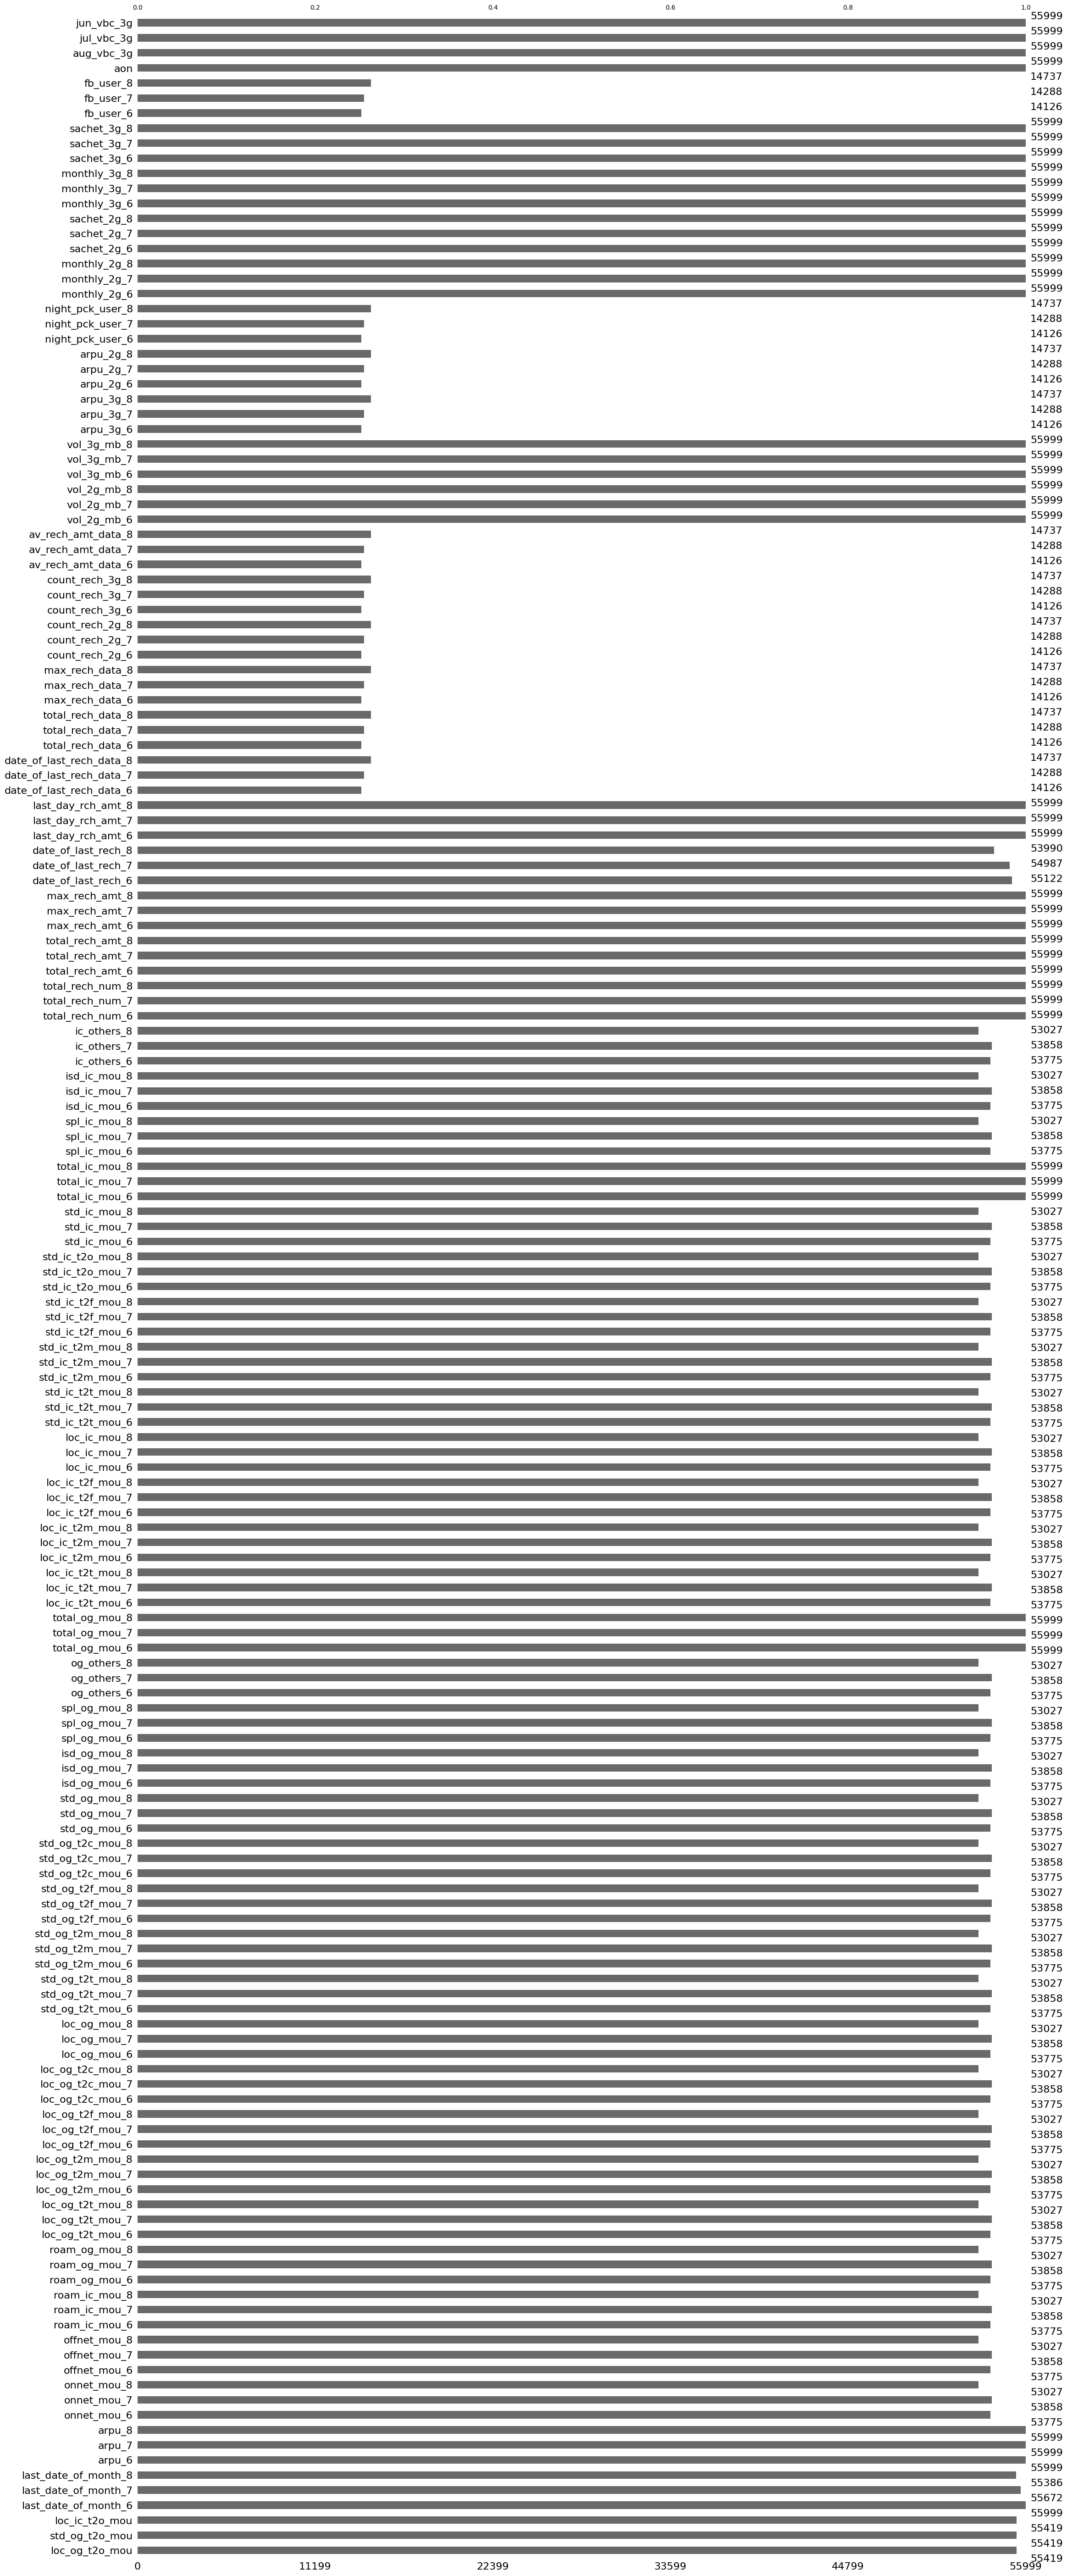

In [13]:
#Visualizing missing data in the dataset
msno.bar(X_train)

<Axes: >

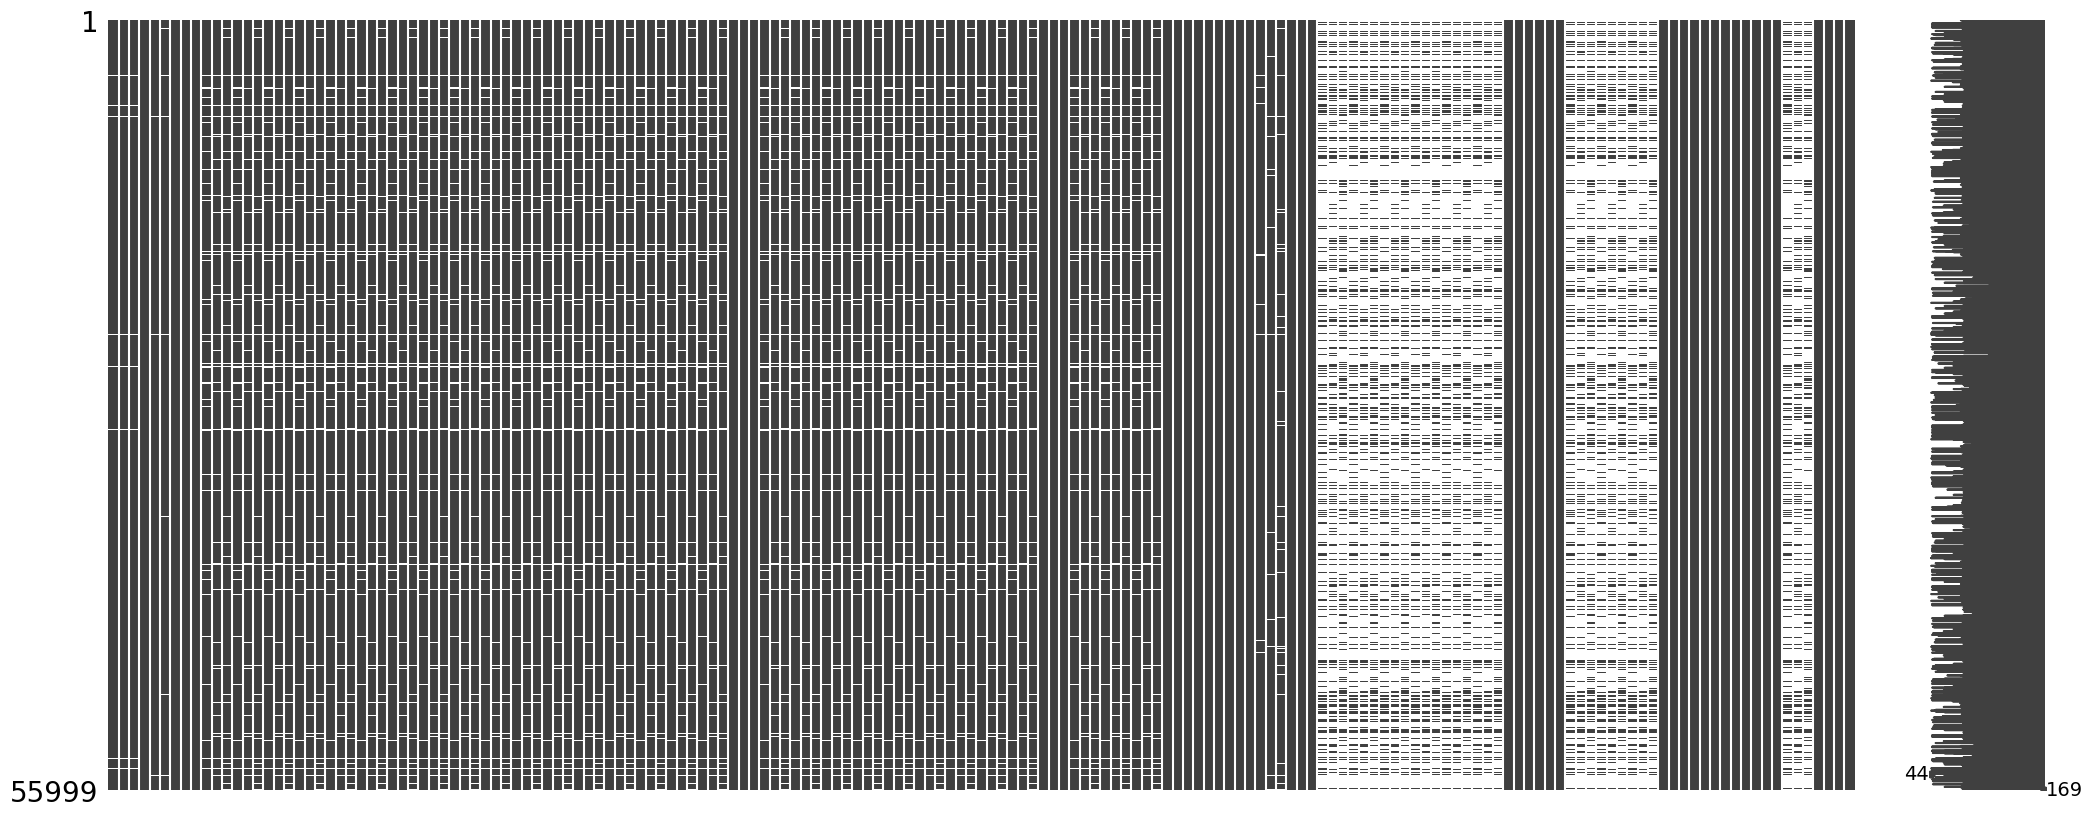

In [14]:
msno.matrix(X_train)

Looks like there are some clusters of missing data

In [15]:
missing_data_percent = 100*X_train.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

date_of_last_rech_data_6    74.774550
count_rech_3g_6             74.774550
arpu_3g_6                   74.774550
av_rech_amt_data_6          74.774550
fb_user_6                   74.774550
night_pck_user_6            74.774550
arpu_2g_6                   74.774550
count_rech_2g_6             74.774550
max_rech_data_6             74.774550
total_rech_data_6           74.774550
arpu_3g_7                   74.485259
max_rech_data_7             74.485259
total_rech_data_7           74.485259
count_rech_3g_7             74.485259
av_rech_amt_data_7          74.485259
arpu_2g_7                   74.485259
night_pck_user_7            74.485259
fb_user_7                   74.485259
count_rech_2g_7             74.485259
date_of_last_rech_data_7    74.485259
av_rech_amt_data_8          73.683459
total_rech_data_8           73.683459
max_rech_data_8             73.683459
count_rech_3g_8             73.683459
count_rech_2g_8             73.683459
arpu_3g_8                   73.683459
date_of_last

Since too much missing information would make a column not really a great predictor for churn, we drop these columns and keep only the ones which have less than 30% missing data.

In [16]:
new_vars = missing_data_percent[missing_data_percent.le(30)].index
new_vars

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou',
       'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8',
       'arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6',
       ...
       'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6',
       'sachet_3g_7', 'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g',
       'jun_vbc_3g'],
      dtype='object', length=139)

In [17]:
X_train_filtered = X_train[new_vars]
X_train_filtered.shape

(55999, 139)

Lets check the missing values again

In [18]:
missing_data_percent = 100*X_train_filtered.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

spl_ic_mou_8            5.307238
isd_ic_mou_8            5.307238
std_ic_t2m_mou_8        5.307238
std_ic_t2t_mou_8        5.307238
loc_ic_mou_8            5.307238
loc_ic_t2f_mou_8        5.307238
loc_og_t2t_mou_8        5.307238
loc_og_t2m_mou_8        5.307238
roam_og_mou_8           5.307238
roam_ic_mou_8           5.307238
loc_og_t2c_mou_8        5.307238
loc_og_t2f_mou_8        5.307238
loc_ic_t2m_mou_8        5.307238
std_ic_t2f_mou_8        5.307238
onnet_mou_8             5.307238
offnet_mou_8            5.307238
ic_others_8             5.307238
std_ic_mou_8            5.307238
std_og_t2c_mou_8        5.307238
spl_og_mou_8            5.307238
loc_ic_t2t_mou_8        5.307238
og_others_8             5.307238
std_og_t2m_mou_8        5.307238
std_og_t2f_mou_8        5.307238
std_og_t2t_mou_8        5.307238
loc_og_mou_8            5.307238
isd_og_mou_8            5.307238
std_ic_t2o_mou_8        5.307238
std_og_mou_8            5.307238
loc_ic_mou_6            3.971499
loc_og_t2t

In [19]:
# Lets also find features which have constant values
nonunique_features = [feature for feature in X_train_filtered.columns if X_train_filtered[feature].nunique() == 1]
len(nonunique_features)

12

In [20]:
# Lets see those features
X_train_filtered[nonunique_features].head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
38586             0.0             0.0             0.0            6/30/2014   
4799              0.0             0.0             0.0            6/30/2014   
25257             0.0             0.0             0.0            6/30/2014   
44059             0.0             0.0             0.0            6/30/2014   
29081             0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8  std_og_t2c_mou_6  \
id                                                                  
38586            7/31/2014            8/31/2014               0.0   
4799             7/31/2014            8/31/2014               0.0   
25257            7/31/2014            8/31/2014               0.0   
44059            7/31/2014            8/31/2014               0.0   
29081            7/31/2014            8/31/2014               0.0   

       std_og_t2c_mou_7  std_og_t2c_mou_8  std_ic_t2o_mou_6  std_ic_t2o_mou_7  \
id                                                                              
38586               0.0               0.0               0.0               0.0   
4799                0.0               0.0               0.0               0.0   
25257               0.0               0.0               0.0               0.0   
44059               0.0               0.0               0.0               0.0   
29081               0.0               0.0               0.0               0.0   

       std_ic_t2o_mou_8  
id                       
38586               0.0  
4799                0.0  
25257               0.0  
44059               0.0  
29081               0.0

In [21]:
# Lets drop these features

X_train_filtered.drop(nonunique_features, axis=1, inplace=True)

In [22]:
# Check missing values again
missing_data_percent = 100*X_train_filtered.isnull().sum()/len(y_train)
missing_data_percent.sort_values(ascending=False)

ic_others_8            5.307238
offnet_mou_8           5.307238
roam_ic_mou_8          5.307238
roam_og_mou_8          5.307238
isd_ic_mou_8           5.307238
spl_ic_mou_8           5.307238
loc_og_t2c_mou_8       5.307238
loc_og_mou_8           5.307238
loc_og_t2t_mou_8       5.307238
loc_og_t2m_mou_8       5.307238
loc_og_t2f_mou_8       5.307238
onnet_mou_8            5.307238
loc_ic_t2m_mou_8       5.307238
std_og_mou_8           5.307238
std_og_t2f_mou_8       5.307238
loc_ic_mou_8           5.307238
std_ic_t2m_mou_8       5.307238
std_ic_t2t_mou_8       5.307238
std_og_t2t_mou_8       5.307238
std_og_t2m_mou_8       5.307238
std_ic_mou_8           5.307238
std_ic_t2f_mou_8       5.307238
og_others_8            5.307238
loc_ic_t2t_mou_8       5.307238
spl_og_mou_8           5.307238
loc_ic_t2f_mou_8       5.307238
isd_og_mou_8           5.307238
std_og_t2t_mou_6       3.971499
loc_og_t2f_mou_6       3.971499
loc_og_mou_6           3.971499
loc_og_t2t_mou_6       3.971499
roam_og_

There are multiple ways to deal with missing values. Some of the quickest way is using the following strategy:

- For numerical columns use "Median"
- For categorical columns use "Mode"

We can also use an advanced Imputer called MICE (Multiple Imputation by Chained Equation). It is an advanced missing data imputation technique that uses multiple iterations of Machine Learning model training to predict the missing values using known values from other features in the data as predictors. There is a library called fancyimputer that implements this, but it is very computationally expensive so defaulting to simpler techniques

In [23]:
# Prior to that lets try to process "recharge columns"
#Impute columns related to recharge with 0
rech_cols = ['total_rech_num_6','total_rech_num_7','total_rech_num_8','total_rech_amt_6','total_rech_amt_7','total_rech_amt_8',
'max_rech_amt_6','max_rech_amt_7','max_rech_amt_8','last_day_rch_amt_6','last_day_rch_amt_7','last_day_rch_amt_8']
X_train_filtered[rech_cols] = X_train_filtered[rech_cols].apply(lambda x: x.fillna(0))

In [24]:
# Process date columns
date_cols = X_train_filtered.select_dtypes(include="object").columns
date_cols

Index(['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8'], dtype='object')

These date columns could be useful for predicting churn, so lets try to derive the days from last recharge from a date beyound the dataset

In [25]:
date_of_last_rech = ['date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8']

In [26]:
from datetime import date
date_beyond_dataset = date(2014, 9, 30)

In [27]:
# convert date_cols to datetime
# select max() date in date_cols and compute the diff with 'date_beyond_dataset' in days
# drop date_cols, add a new column with 'new_col_name' with a count of days
# df[date_cols].apply(pd.to_datetime)

def day_counts(df, date_cols, today, new_col_name):   
    df[new_col_name] = (pd.Timestamp(date_beyond_dataset) - df[date_cols].apply(pd.to_datetime).max(axis=1)).dt.days 
    df.drop(date_cols, axis=1, inplace=True)

In [28]:
day_counts(X_train_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')

In [29]:
X_train_filtered[['days_from_last_recharge']].isnull().mean()

days_from_last_recharge    0.000982
dtype: float64

In [30]:
X_train_filtered[['days_from_last_recharge']] = X_train_filtered[['days_from_last_recharge']].fillna(-1)

In [31]:
# Check if all columns are numeric
X_train_filtered.dtypes 

arpu_6                     float64
arpu_7                     float64
arpu_8                     float64
onnet_mou_6                float64
onnet_mou_7                float64
onnet_mou_8                float64
offnet_mou_6               float64
offnet_mou_7               float64
offnet_mou_8               float64
roam_ic_mou_6              float64
roam_ic_mou_7              float64
roam_ic_mou_8              float64
roam_og_mou_6              float64
roam_og_mou_7              float64
roam_og_mou_8              float64
loc_og_t2t_mou_6           float64
loc_og_t2t_mou_7           float64
loc_og_t2t_mou_8           float64
loc_og_t2m_mou_6           float64
loc_og_t2m_mou_7           float64
loc_og_t2m_mou_8           float64
loc_og_t2f_mou_6           float64
loc_og_t2f_mou_7           float64
loc_og_t2f_mou_8           float64
loc_og_t2c_mou_6           float64
loc_og_t2c_mou_7           float64
loc_og_t2c_mou_8           float64
loc_og_mou_6               float64
loc_og_mou_7        

In [32]:
missing_data_percent = X_train_filtered.isnull().any()
impute_cols = missing_data_percent[missing_data_percent.gt(0)].index
impute_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2t_mou_6', 'loc_og_t2t_mou_7', 'loc_og_t2t_mou_8',
       'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7', 'loc_og_t2m_mou_8',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2f_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2t_mou_8', 'std_og_t2m_mou_6',
       'std_og_t2m_mou_7', 'std_og_t2m_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'loc_ic_t2t_mou_6', 'loc_ic_t2t_mou_7',
       'lo

In [33]:
imp = SimpleImputer(strategy='constant', fill_value=0)
X_train_filtered[impute_cols] = imp.fit_transform(X_train_filtered[impute_cols])

<Axes: >

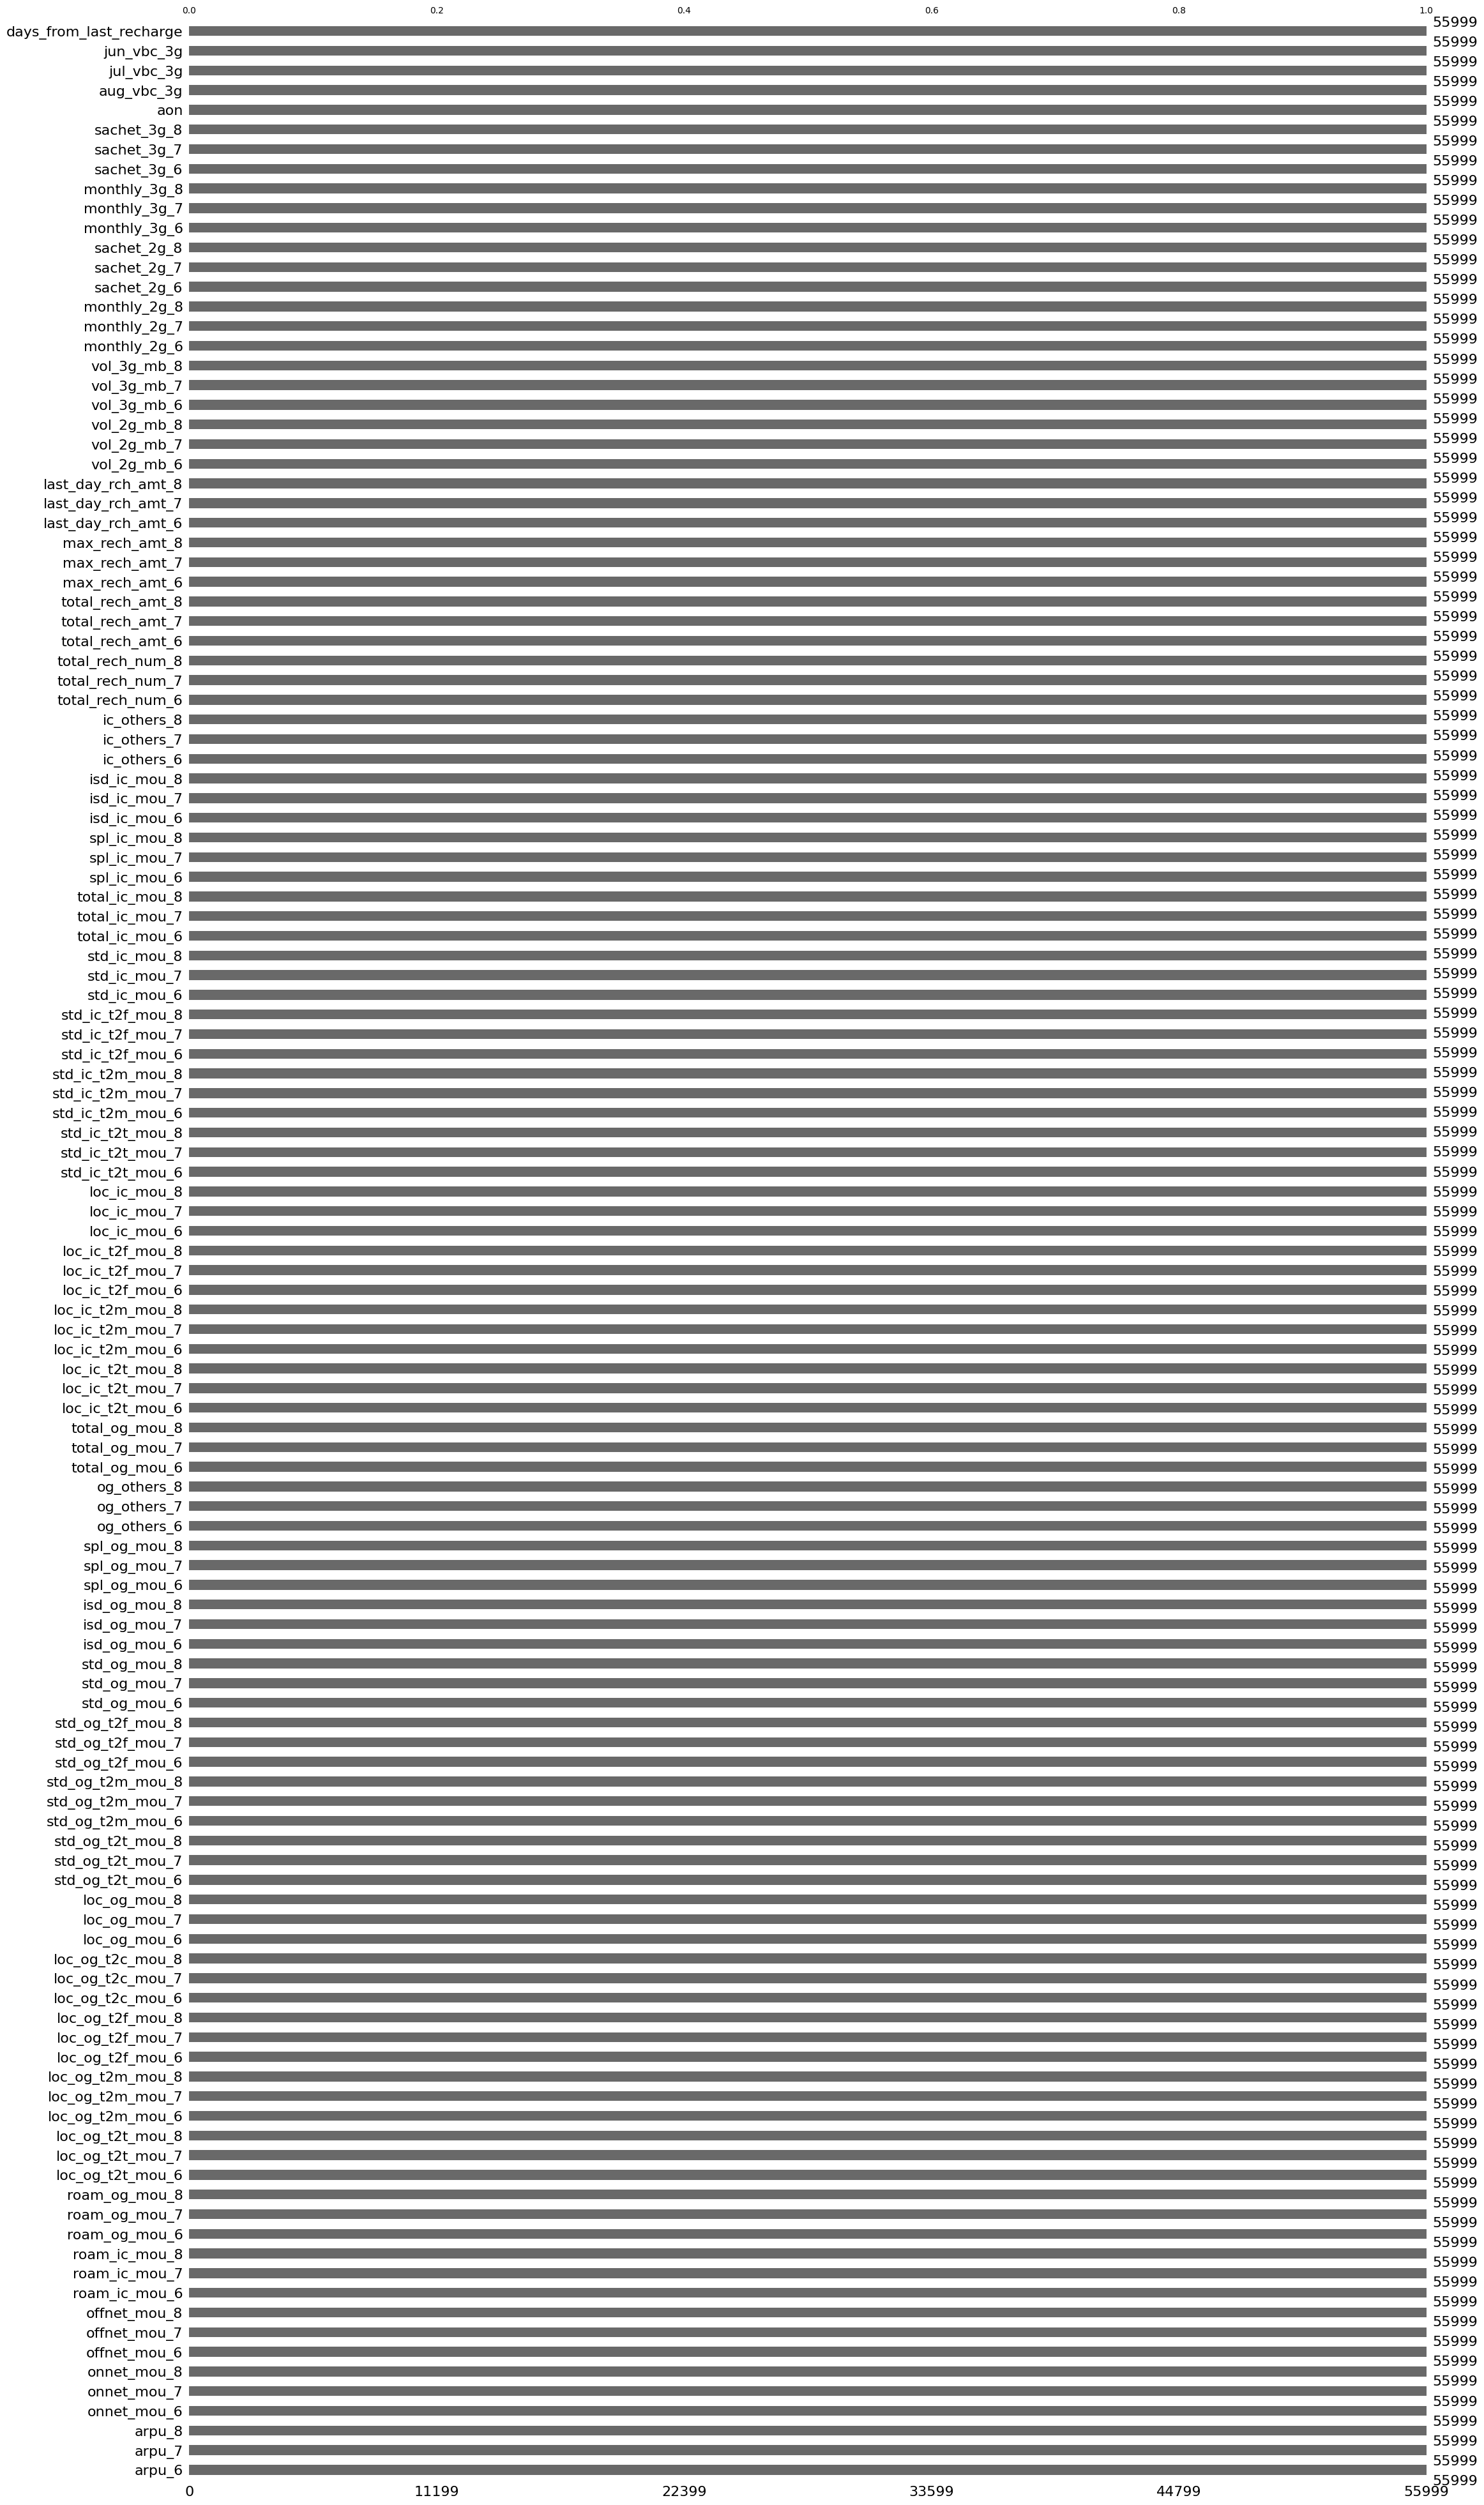

In [34]:
#Lets visualize missing data now
msno.bar(X_train_filtered)

In [35]:
X_train_filtered.isna().mean()

arpu_6                     0.0
arpu_7                     0.0
arpu_8                     0.0
onnet_mou_6                0.0
onnet_mou_7                0.0
onnet_mou_8                0.0
offnet_mou_6               0.0
offnet_mou_7               0.0
offnet_mou_8               0.0
roam_ic_mou_6              0.0
roam_ic_mou_7              0.0
roam_ic_mou_8              0.0
roam_og_mou_6              0.0
roam_og_mou_7              0.0
roam_og_mou_8              0.0
loc_og_t2t_mou_6           0.0
loc_og_t2t_mou_7           0.0
loc_og_t2t_mou_8           0.0
loc_og_t2m_mou_6           0.0
loc_og_t2m_mou_7           0.0
loc_og_t2m_mou_8           0.0
loc_og_t2f_mou_6           0.0
loc_og_t2f_mou_7           0.0
loc_og_t2f_mou_8           0.0
loc_og_t2c_mou_6           0.0
loc_og_t2c_mou_7           0.0
loc_og_t2c_mou_8           0.0
loc_og_mou_6               0.0
loc_og_mou_7               0.0
loc_og_mou_8               0.0
std_og_t2t_mou_6           0.0
std_og_t2t_mou_7           0.0
std_og_t

All the missing data has been handled

Lets check for duplicate data

In [36]:
X_train_filtered.duplicated().sum()

0

There are no duplicate data in the train set

# 4. Exploratory Data Analysis & Preprocessing

Lets process the numerical columns in terms of outliers and univariate/bivariate/multivariate analysis

In [37]:
# Since the number of columns are pretty high, doing nay univariate analysis of all these columns would be impossible. Lets use the describe function to analyze
X_train_filtered.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     282.904076    278.746656    279.361287    128.195282    129.669448   
std      337.585141    349.781373    358.875569    295.200244    309.681047   
min    -2041.228000  -1289.715000   -945.808000      0.000000      0.000000   
25%       93.400500     86.616500     84.142000      5.360000      4.840000   
50%      197.240000    191.421000    192.080000     30.610000     29.080000   
75%      369.544500    365.058000    370.817500    113.240000    109.000000   
90%      619.924800    617.095000    614.906200    333.116000    336.890000   
95%      829.975600    824.405500    828.867400    601.698000    617.333000   
99%     1411.760960   1425.757260   1457.550460   1429.066600   1472.792000   
max    27731.088000  35145.834000  33543.624000   7376.710000   8157.780000   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000   55999.000000   
mean     126.274331    189.569107    188.726754    185.476939       9.607260   
std      306.941518    312.351862    317.783934    315.477480      57.149356   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        4.090000     28.460000     26.620000     23.600000       0.000000   
50%       27.760000     89.440000     85.410000     82.980000       0.000000   
75%      105.925000    221.075000    217.810000    215.370000       0.000000   
90%      327.398000    464.124000    468.298000    466.398000      10.942000   
95%      598.202000    714.452000    724.191000    712.384000      39.713000   
99%     1448.973800   1523.414400   1515.842200   1485.576800     219.736600   
max    10752.560000   8362.360000   7043.980000  14007.340000    2613.310000   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        6.926835       6.758256      13.873145       9.611994   
std        56.594361      52.488221      74.249628      57.540216   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.530000       4.460000      21.010000       8.730000   
95%        22.260000      22.440000      66.213000      40.935000   
99%       155.615600     152.991800     286.811000     221.090000   
max      4155.830000    4169.810000    3775.110000    1900.060000   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   55999.000000      55999.000000      55999.000000      55999.000000   
mean        9.359577         44.940986         44.423310         43.468299   
std        59.931211        146.861176        152.043468        151.724005   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.000000          1.000000          0.760000   
50%         0.000000         10.560000         10.340000         10.010000   
75%         0.000000         38.480000         37.640000         37.280000   
90%         7.864000        100.810000         98.310000         97.482000   
95%        39.844000        172.995000        169.886000        169.962000   
99%       209.692400        539.752800        517.138000        511.212800   
max      2939.860000       6431.330000       7400.660000      10752.560000   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          88.910265         86.954976         86.099190          3.568152   
std          159.129479        151.471976        150.014187         13.164917   
min          

From the above table it is pretty evident that there are lots of outliers in the data and next step we will remove these outliers

### 4.1 Handling outliers


These outliers can be capped with k-sigma method.


In [38]:
# Define a function to remove outliers

def cap_outliers(array, k=3):
    upper_limit = array.mean() + k*array.std()
    lower_limit = array.mean() - k*array.std()
    array[array<lower_limit] = lower_limit
    array[array>upper_limit] = upper_limit
    return array

In [39]:
X_train_filtered = X_train_filtered.apply(cap_outliers, axis=0)

In [40]:
# Lets check the dataframe again to check the summary statistics
X_train_filtered.describe(percentiles=(0.25, 0.50, 0.75, 0.90, 0.95, 0.99))

arpu_6        arpu_7        arpu_8   onnet_mou_6   onnet_mou_7  \
count  55999.000000  55999.000000  55999.000000  55999.000000  55999.000000   
mean     275.102566    270.982774    271.541354    114.987774    115.965089   
std      263.576213    266.305299    270.203660    209.260284    216.742225   
min     -729.851347   -770.597464   -797.265421      0.000000      0.000000   
25%       93.400500     86.616500     84.142000      5.360000      4.840000   
50%      197.240000    191.421000    192.080000     30.610000     29.080000   
75%      369.544500    365.058000    370.817500    113.240000    109.000000   
90%      619.924800    617.095000    614.906200    333.116000    336.890000   
95%      829.975600    824.405500    828.867400    601.698000    617.333000   
99%     1295.659500   1328.090776   1355.987994   1013.796014   1058.712588   
max     1295.659500   1328.090776   1355.987994   1013.796014   1058.712588   

        onnet_mou_8  offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  \
count  55999.000000  55999.000000  55999.000000  55999.000000   55999.000000   
mean     112.798417    177.128805    176.258642    173.473671       6.955187   
std      212.245054    237.170892    240.799179    238.596533      26.928828   
min        0.000000      0.000000      0.000000      0.000000       0.000000   
25%        4.090000     28.460000     26.620000     23.600000       0.000000   
50%       27.760000     89.440000     85.410000     82.980000       0.000000   
75%      105.925000    221.075000    217.810000    215.370000       0.000000   
90%      327.398000    464.124000    468.298000    466.398000      10.942000   
95%      598.202000    714.452000    724.191000    712.384000      39.713000   
99%     1047.098885   1126.624694   1142.078557   1131.909379     181.055328   
max     1047.098885   1126.624694   1142.078557   1131.909379     181.055328   

       roam_ic_mou_7  roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  \
count   55999.000000   55999.000000   55999.000000   55999.000000   
mean        4.762673       4.633324      10.413234       6.801749   
std        21.868709      20.905757      37.388067      27.296049   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       0.000000       0.000000       0.000000   
90%         4.530000       4.460000      21.010000       8.730000   
95%        22.260000      22.440000      66.213000      40.935000   
99%       155.615600     152.991800     236.622027     182.232643   
max       176.709917     164.222919     236.622027     182.232643   

       roam_og_mou_8  loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  \
count   55999.000000      55999.000000      55999.000000      55999.000000   
mean        6.684269         38.508762         37.927382         37.435498   
std        27.311467         76.957289         76.901636         76.169407   
min         0.000000          0.000000          0.000000          0.000000   
25%         0.000000          1.000000          1.000000          0.760000   
50%         0.000000         10.560000         10.340000         10.010000   
75%         0.000000         38.480000         37.640000         37.280000   
90%         7.864000        100.810000         98.310000         97.482000   
95%        39.844000        172.995000        169.886000        169.962000   
99%       189.153211        485.524514        500.553714        498.640313   
max       189.153211        485.524514        500.553714        498.640313   

       loc_og_t2m_mou_6  loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  \
count      55999.000000      55999.000000      55999.000000      55999.000000   
mean          82.762649         81.099436         80.389408          3.007222   
std          118.037036        114.630377        114.174215          7.580470   
min          

Lets also plot the correlations for each feature for bivariate analysis.

In [41]:
data_eda = pd.concat([X_train_filtered, y_train], axis=1)
data_eda.head()

arpu_6   arpu_7   arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
id                                                                        
38586   18.080  200.118    7.720         0.00        31.04     6.950000   
4799   253.987  334.951  712.723       366.56       605.61  1047.098885   
25257  206.348  297.970  401.941        31.34        37.09    72.010000   
44059   80.141  107.471   82.996        35.89        44.78    55.790000   
29081  192.482  178.162  145.594        55.38        79.03    86.210000   

       offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
id                                                                              
38586         18.83        144.96          1.09            0.0            0.0   
4799         102.24        114.98        208.24            0.0            0.0   
25257        209.36        195.33        231.66            0.0            0.0   
44059         65.09         84.66         51.04            0.0            0.0   
29081        152.84        128.13         76.98            0.0            0.0   

       roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  \
id                                                                  
38586            0.0            0.0            0.0            0.0   
4799             0.0            0.0            0.0            0.0   
25257            0.0            0.0            0.0            0.0   
44059            0.0            0.0            0.0            0.0   
29081            0.0            0.0            0.0            0.0   

       loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  \
id                                                                              
38586              0.00             31.04              6.95             18.83   
4799               1.68              8.23             12.46             11.11   
25257             16.68              0.00              5.23             96.59   
44059             35.89             44.78             55.79             64.91   
29081             55.38             38.69             85.28            148.26   

       loc_og_t2m_mou_7  loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  \
id                                                                              
38586            143.91              1.09              0.00              1.05   
4799              26.79             17.71              0.00              0.00   
25257            124.56            133.83              2.05              3.26   
44059             84.66             51.04              0.00              0.00   
29081            120.53             72.26              3.98              7.59   

       loc_og_t2f_mou_8  loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  \
id                                                                              
38586              0.00              0.00               0.0              0.00   
4799               0.00              0.00               0.0              0.00   
25257              4.64              0.01               0.0              0.00   
44059              0.00              0.18               0.0              0.00   
29081              1.83              0.00               0.0              0.75   

       loc_og_mou_6  loc_og_mou_7  loc_og_mou_8  std_og_t2t_mou_6  \
id                                                                  
38586         18.83        176.01          8.04              0.00   
4799          12.79         35.03         30.18            364.88   
25257        115.33        127.83        143.71             14.66   
44059        100.81        129.44        106.84              0.00   
29081        207.63        166.83        159.38              0.00   

       std_og_t2t_mou_7  std_og_t2t_mou_8  std_og_t2m_mou_6  std_og_t2m_mou_7  \
id                                                                              
38586              0.00          0.000000              0.00              0.00   

There seems to be light correlation, Lets do a deep dive

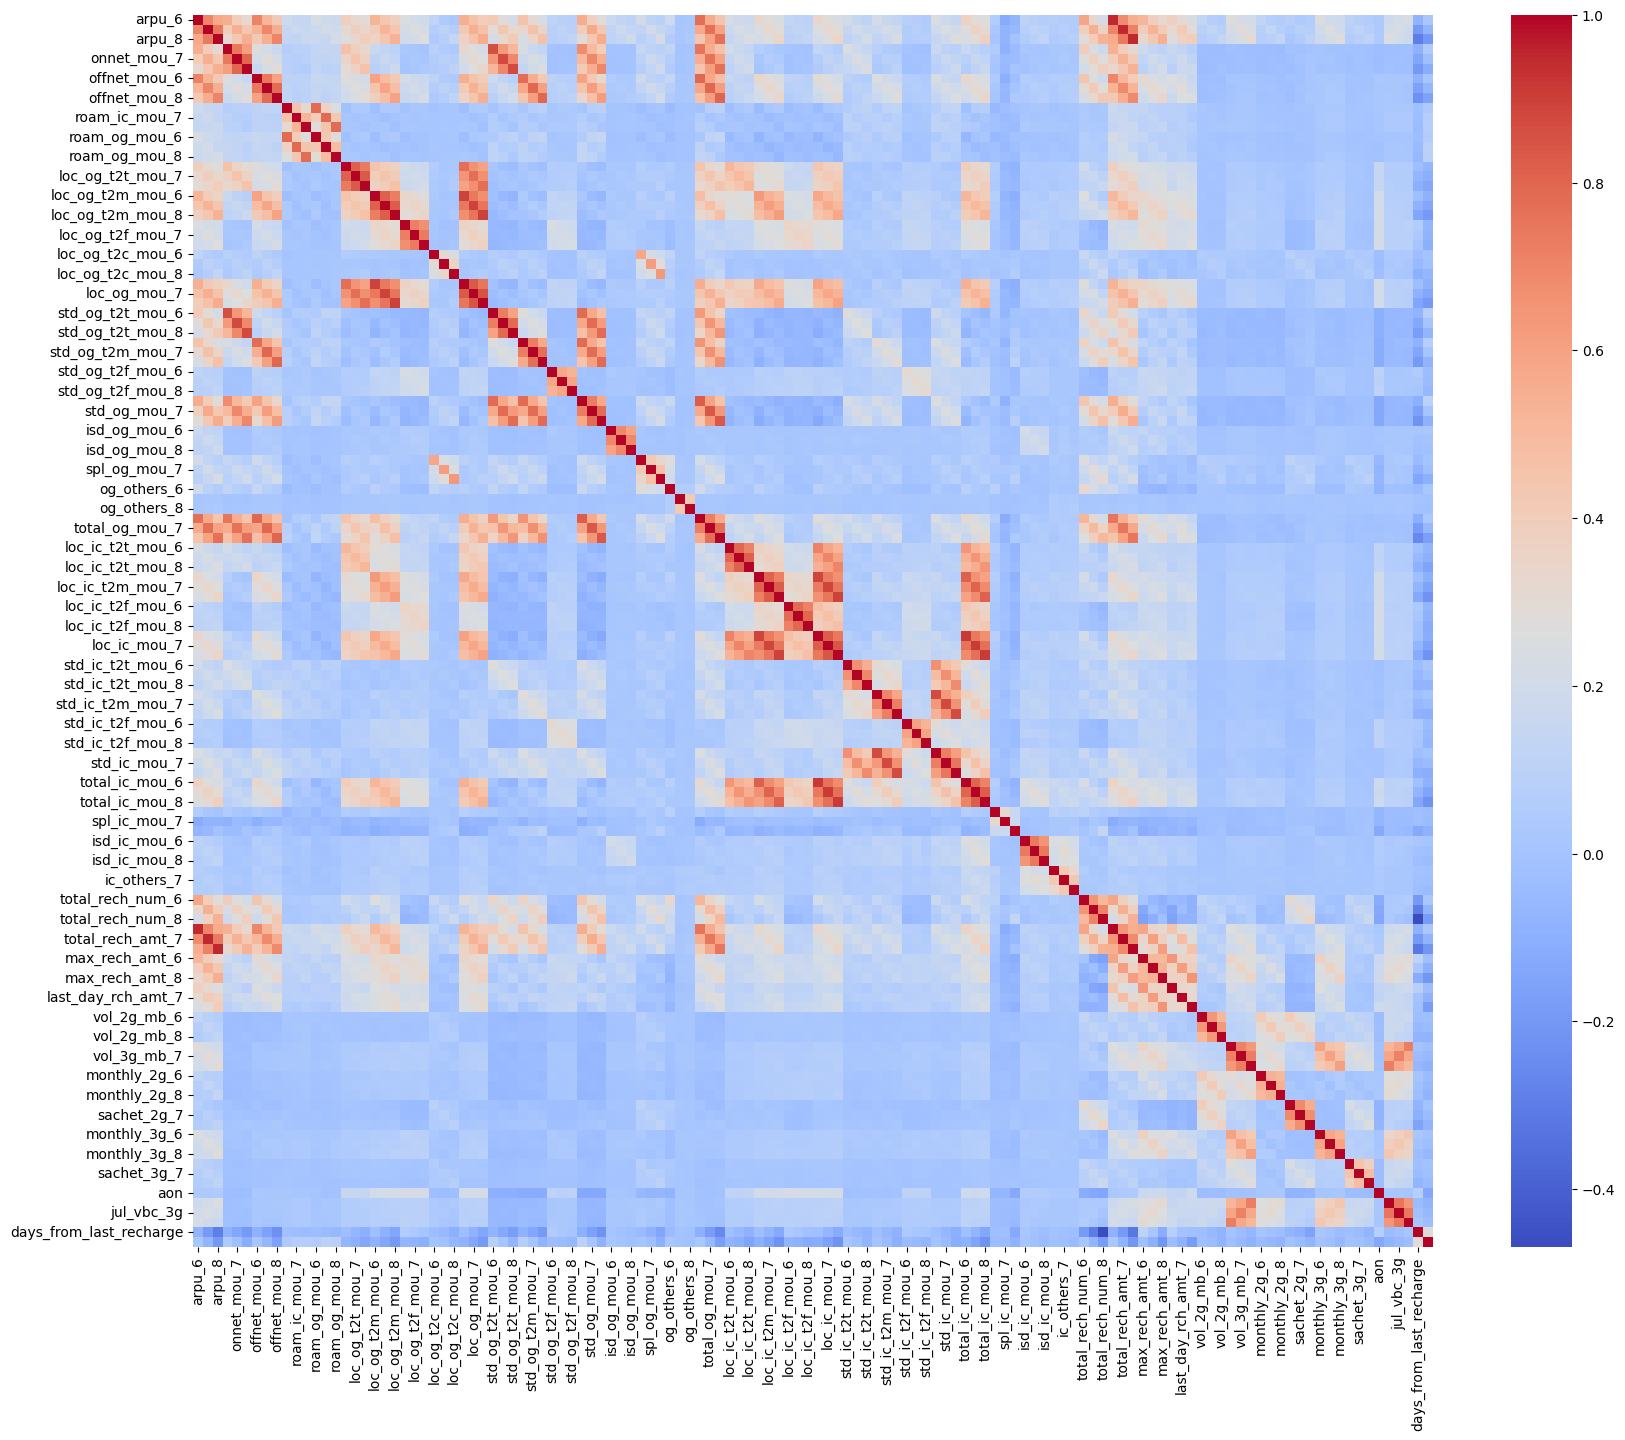

In [42]:
# Lets check the correlations of the numeric variables with each other and with "churn_probability"
plt.figure(figsize=(20, 16))
sns.heatmap(data_eda.corr(), cmap="coolwarm")
plt.show()

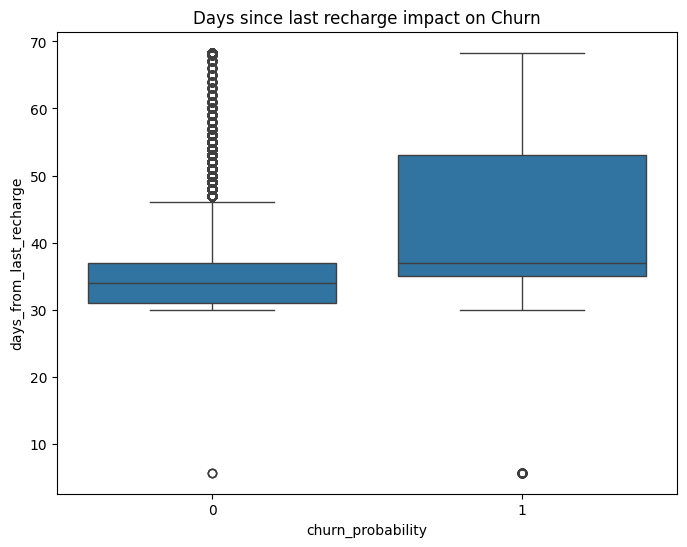

In [43]:
# Lets check the correlation between days from last recharge column we derived in last section and churn probability
plt.figure(figsize=[8, 6])
sns.boxplot(data=data_eda, x='churn_probability', y='days_from_last_recharge')
plt.title("Days since last recharge impact on Churn")
plt.show()

There seems to be higher churn for folks with higher number of days without recharge

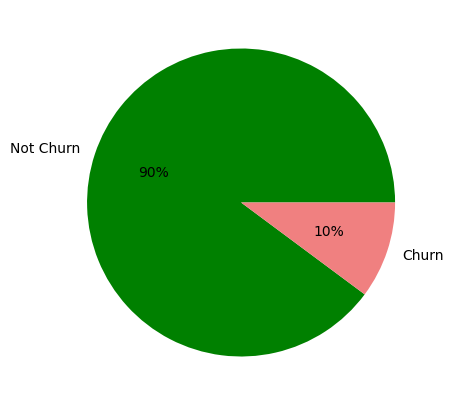

In [44]:
# Plot churn_probability
plt.figure(figsize= (6,5)) 
labels = ['Not Churn','Churn']
colors = ['green', 'lightcoral']
plt.pie(data_eda.churn_probability.value_counts(), labels=labels, colors = colors, autopct = '%0.0f%%')
plt.show()

The data is imbalanced so we may have to apply class imbalance techniques prior to training models

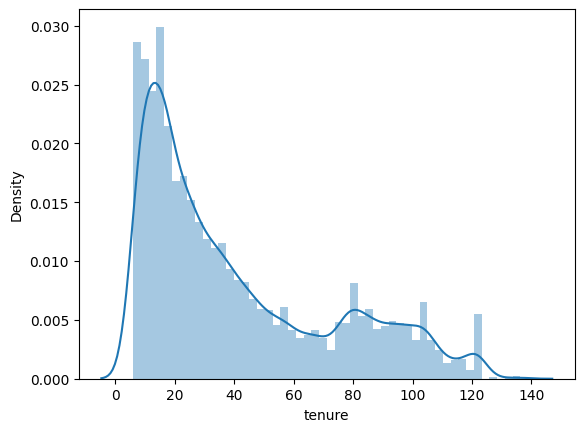

In [45]:
# Lets check churn probability w.r.t tenure or age on network varaible
data_eda["tenure"] = data_eda["aon"]/30
sns.distplot(data_eda["tenure"], bins=50)
plt.show()

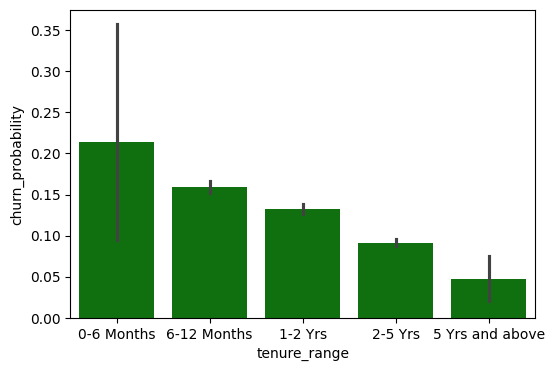

In [46]:
tenure_range = [0, 6, 12, 24, 60, 61]
tenure_label = ['0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
data_eda['tenure_range'] = pd.cut(data_eda['tenure'], tenure_range, labels=tenure_label)
plt.figure(figsize=[6,4])
sns.barplot(x='tenure_range', y='churn_probability', data=data_eda, color='g')
plt.show()

Its evident from above plot that maximum churn happens during first 6 months and as time goes by, less churn happens.

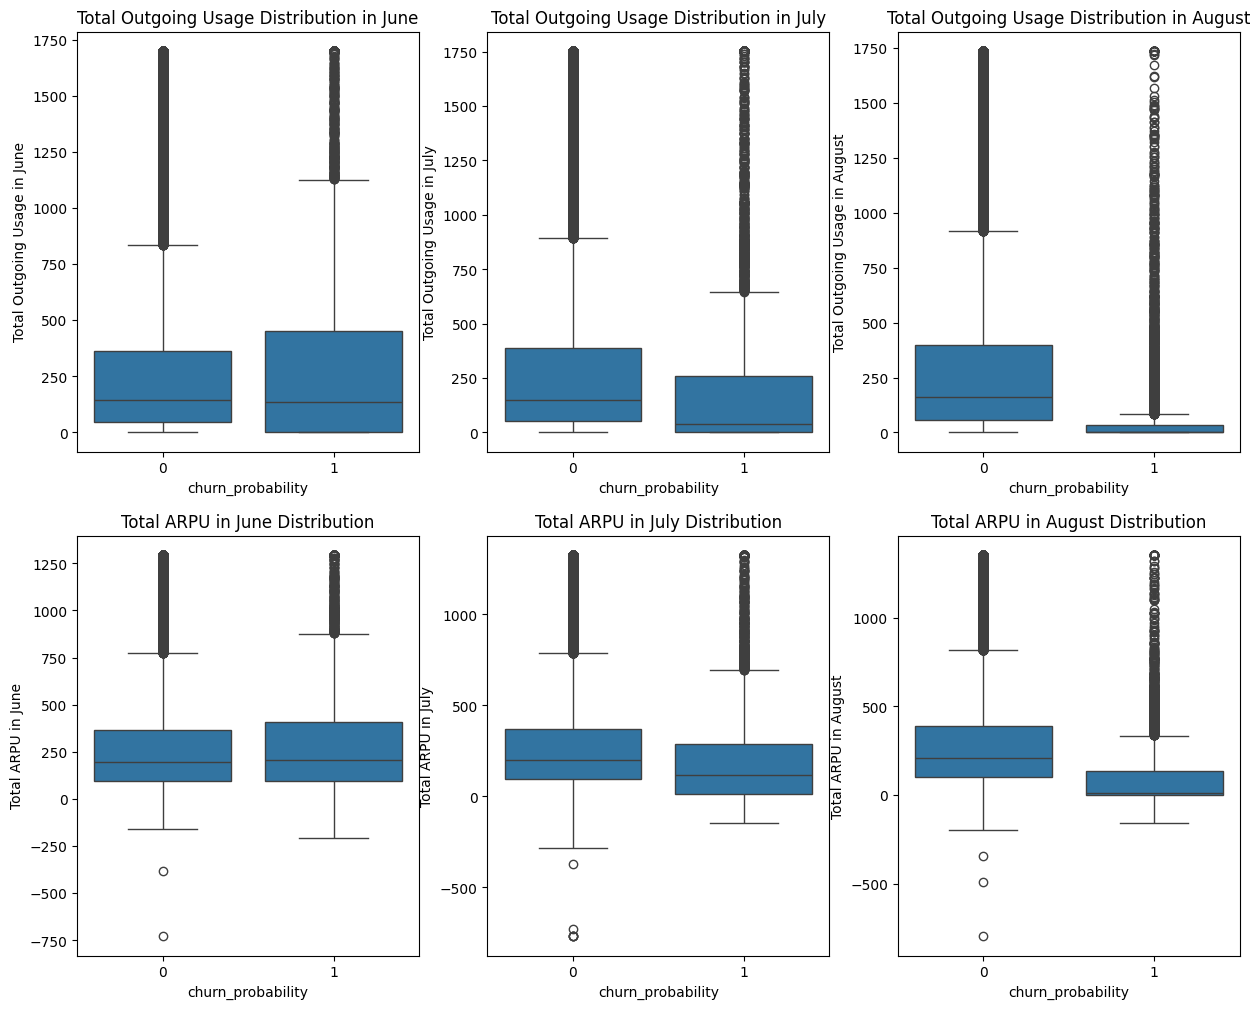

In [47]:
plt.figure(figsize=[15, 12])
plt.subplot(231)
sns.boxplot(x="churn_probability", y='total_og_mou_6', data=data_eda)
plt.ylabel('Total Outgoing Usage in June')
plt.title("Total Outgoing Usage Distribution in June")

plt.subplot(232)
sns.boxplot(x="churn_probability", y='total_og_mou_7', data=data_eda)
plt.ylabel('Total Outgoing Usage in July')
plt.title("Total Outgoing Usage Distribution in July")

plt.subplot(233)
sns.boxplot(x="churn_probability", y='total_og_mou_8', data=data_eda)
plt.ylabel('Total Outgoing Usage in August')
plt.title("Total Outgoing Usage Distribution in August")

plt.subplot(234)
sns.boxplot(x="churn_probability", y='arpu_6', data=data_eda)
plt.ylabel('Total ARPU in June')
plt.title("Total ARPU in June Distribution")

plt.subplot(235)
sns.boxplot(x="churn_probability", y='arpu_7', data=data_eda)
plt.ylabel('Total ARPU in July')
plt.title("Total ARPU in July Distribution")

plt.subplot(236)
sns.boxplot(x="churn_probability", y='arpu_8', data=data_eda)
plt.ylabel('Total ARPU in August')
plt.title("Total ARPU in August Distribution")

plt.show()

**Analysis**:

- Customers with higher outgoing calls in the sixth month with reduction of calls/usage in eighth month have a high chance of churning
- As the ARPU of the customer decreases from sixth to eighth month, the probability of churn increases

# 5. Feature Engineering and Selection

In this section we will try to add some derived metrics to increase the chances of a better model for example

- "Average gain/loss of 3g and 2g data volume from month 6 to 8" - (growth or decline of 3g usage month over month?)

- "Difference in usage for outgoing and incoming calls over 3 months etc.

It is also observed from data that so of these columns are just sum of individual usage, for example:-
"loc_og_mou_6" is just sum of usage of 'loc_og_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2f_mou_6' and 'loc_og_t2c_mou_6'. This will repeat for "loc_og_mou_7", ""loc_og_mou_8" etc.

Other variables also show similar trend like "std_og_mou_6", "loc_ic_mou_6" and their corresponding 7th and 8th months
Its best to just use the total variables and drop the individual compomnents.

After that we will compute differences of usage for roam, STD, ISD, data etc. from month 8 to month 7 and 6

In [48]:
pd.DataFrame(X_train_filtered.columns.T)

0
0                     arpu_6
1                     arpu_7
2                     arpu_8
3                onnet_mou_6
4                onnet_mou_7
5                onnet_mou_8
6               offnet_mou_6
7               offnet_mou_7
8               offnet_mou_8
9              roam_ic_mou_6
10             roam_ic_mou_7
11             roam_ic_mou_8
12             roam_og_mou_6
13             roam_og_mou_7
14             roam_og_mou_8
15          loc_og_t2t_mou_6
16          loc_og_t2t_mou_7
17          loc_og_t2t_mou_8
18          loc_og_t2m_mou_6
19          loc_og_t2m_mou_7
20          loc_og_t2m_mou_8
21          loc_og_t2f_mou_6
22          loc_og_t2f_mou_7
23          loc_og_t2f_mou_8
24          loc_og_t2c_mou_6
25          loc_og_t2c_mou_7
26          loc_og_t2c_mou_8
27              loc_og_mou_6
28              loc_og_mou_7
29              loc_og_mou_8
30          std_og_t2t_mou_6
31          std_og_t2t_mou_7
32          std_og_t2t_mou_8
33          std_og_t2m_mou_6
34          std_og_t2m_mou_7
35          std_og_t2m_mou_8
36          std_og_t2f_mou_6
37          std_og_t2f_mou_7
38          std_og_t2f_mou_8
39              std_og_mou_6
40              std_og_mou_7
41              std_og_mou_8
42              isd_og_mou_6
43              isd_og_mou_7
44              isd_og_mou_8
45              spl_og_mou_6
46              spl_og_mou_7
47              spl_og_mou_8
48               og_others_6
49               og_others_7
50               og_others_8
51            total_og_mou_6
52            total_og_mou_7
53            total_og_mou_8
54          loc_ic_t2t_mou_6
55          loc_ic_t2t_mou_7
56          loc_ic_t2t_mou_8
57          loc_ic_t2m_mou_6
58          loc_ic_t2m_mou_7
59          loc_ic_t2m_mou_8
60          loc_ic_t2f_mou_6
61          loc_ic_t2f_mou_7
62          loc_ic_t2f_mou_8
63              loc_ic_mou_6
64              loc_ic_mou_7
65              loc_ic_mou_8
66          std_ic_t2t_mou_6
67          std_ic_t2t_mou_7
68          std_ic_t2t_mou_8
69          std_ic_t2m_mou_6
70          std_ic_t2m_mou_7
71          std_ic_t2m_mou_8
72          std_ic_t2f_mou_6
73          std_ic_t2f_mou_7
74          std_ic_t2f_mou_8
75              std_ic_mou_6
76              std_ic_mou_7
77              std_ic_mou_8
78            total_ic_mou_6
79            total_ic_mou_7
80            total_ic_mou_8
81              spl_ic_mou_6
82              spl_ic_mou_7
83              spl_ic_mou_8
84              isd_ic_mou_6
85              isd_ic_mou_7
86              isd_ic_mou_8
87               ic_others_6
88               ic_others_7
89               ic_others_8
90          total_rech_num_6
91          total_rech_num_7
92          total_rech_num_8
93          total_rech_amt_6
94          total_rech_amt_7
95          total_rech_amt_8
96            max_rech_amt_6
97            max_rech_amt_7
98            max_rech_amt_8
99        last_day_rch_amt_6
100       last_day_rch_amt_7
101       last_day_rch_amt_8
102              vol_2g_mb_6
103              vol_2g_mb_7
104              vol_2g_mb_8
105              vol_3g_mb_6
106              vol_3g_mb_7
107              vol_3g_mb_8
108             monthly_2g_6
109             monthly_2g_7
110             monthly_2g_8
111              sachet_2g_6
112              sachet_2g_7
113              sachet_2g_8
114             monthly_3g_6
115             monthly_3g_7
116             monthly_3g_8
117              sachet_3g_6
118              sachet_3g_7
119              sachet_3g_8
120                      aon
121               aug_vbc_3g
122               jul_vbc_3g
123               jun_vbc_3g
124  days_from_last_recharge

In [49]:
X_train_filtered['arpu_diff'] = X_train_filtered.arpu_8 - ((X_train_filtered.arpu_6 + X_train_filtered.arpu_7)/2)

X_train_filtered['onnet_mou_diff'] = X_train_filtered.onnet_mou_8 - ((X_train_filtered.onnet_mou_6 + X_train_filtered.onnet_mou_7)/2)

X_train_filtered['offnet_mou_diff'] = X_train_filtered.offnet_mou_8 - ((X_train_filtered.offnet_mou_6 + X_train_filtered.offnet_mou_7)/2)

X_train_filtered['roam_ic_mou_diff'] = X_train_filtered.roam_ic_mou_8 - ((X_train_filtered.roam_ic_mou_6 + X_train_filtered.roam_ic_mou_7)/2)

X_train_filtered['roam_og_mou_diff'] = X_train_filtered.roam_og_mou_8 - ((X_train_filtered.roam_og_mou_6 + X_train_filtered.roam_og_mou_7)/2)

X_train_filtered['loc_og_mou_diff'] = X_train_filtered.loc_og_mou_8 - ((X_train_filtered.loc_og_mou_6 + X_train_filtered.loc_og_mou_7)/2)

X_train_filtered['std_og_mou_diff'] = X_train_filtered.std_og_mou_8 - ((X_train_filtered.std_og_mou_6 + X_train_filtered.std_og_mou_7)/2)

X_train_filtered['isd_og_mou_diff'] = X_train_filtered.isd_og_mou_8 - ((X_train_filtered.isd_og_mou_6 + X_train_filtered.isd_og_mou_7)/2)

X_train_filtered['spl_og_mou_diff'] = X_train_filtered.spl_og_mou_8 - ((X_train_filtered.spl_og_mou_6 + X_train_filtered.spl_og_mou_7)/2)

X_train_filtered['og_others_diff'] = X_train_filtered.og_others_8 - ((X_train_filtered.og_others_6 + X_train_filtered.og_others_7)/2)

X_train_filtered['total_og_mou_diff'] = X_train_filtered.total_og_mou_8 - ((X_train_filtered.total_og_mou_6 + X_train_filtered.total_og_mou_7)/2)

X_train_filtered['loc_ic_mou_diff'] = X_train_filtered.loc_ic_mou_8 - ((X_train_filtered.loc_ic_mou_6 + X_train_filtered.loc_ic_mou_7)/2)

X_train_filtered['std_ic_mou_diff'] = X_train_filtered.std_ic_mou_8 - ((X_train_filtered.std_ic_mou_6 + X_train_filtered.std_ic_mou_7)/2)

X_train_filtered['isd_ic_mou_diff'] = X_train_filtered.isd_ic_mou_8 - ((X_train_filtered.isd_ic_mou_6 + X_train_filtered.isd_ic_mou_7)/2)

X_train_filtered['spl_ic_mou_diff'] = X_train_filtered.spl_ic_mou_8 - ((X_train_filtered.spl_ic_mou_6 + X_train_filtered.spl_ic_mou_7)/2)

X_train_filtered['ic_others_diff'] = X_train_filtered.ic_others_8 - ((X_train_filtered.ic_others_6 + X_train_filtered.ic_others_7)/2)

X_train_filtered['total_ic_mou_diff'] = X_train_filtered.total_ic_mou_8 - ((X_train_filtered.total_ic_mou_6 + X_train_filtered.total_ic_mou_7)/2)

X_train_filtered['total_rech_num_diff'] = X_train_filtered.total_rech_num_8 - ((X_train_filtered.total_rech_num_6 + X_train_filtered.total_rech_num_7)/2)

X_train_filtered['total_rech_amt_diff'] = X_train_filtered.total_rech_amt_8 - ((X_train_filtered.total_rech_amt_6 + X_train_filtered.total_rech_amt_7)/2)

X_train_filtered['max_rech_amt_diff'] = X_train_filtered.max_rech_amt_8 - ((X_train_filtered.max_rech_amt_6 + X_train_filtered.max_rech_amt_7)/2)

X_train_filtered['vol_2g_mb_diff'] = X_train_filtered.vol_2g_mb_8 - ((X_train_filtered.vol_2g_mb_6 + X_train_filtered.vol_2g_mb_7)/2)

X_train_filtered['vol_3g_mb_diff'] = X_train_filtered.vol_3g_mb_8 - ((X_train_filtered.vol_3g_mb_6 + X_train_filtered.vol_3g_mb_7)/2)


In [50]:
columns_to_del = ['loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8',
                  'loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2c_mou_6','loc_og_t2c_mou_7','loc_og_t2c_mou_8',
                  'std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2m_mou_6','std_og_t2m_mou_7','std_og_t2m_mou_8',
                  'std_og_t2f_mou_6','std_og_t2f_mou_7','std_og_t2f_mou_8','loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8',
                  'loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8',
                  'std_ic_t2t_mou_6','std_ic_t2t_mou_7','std_ic_t2t_mou_8','std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8',
                  'std_ic_t2f_mou_6','std_ic_t2f_mou_7','std_ic_t2f_mou_8']
                  

In [51]:
X_train_filtered.drop(columns_to_del, axis=1, inplace = True)

In [52]:
pd.DataFrame(X_train_filtered.columns.T)

0
0                     arpu_6
1                     arpu_7
2                     arpu_8
3                onnet_mou_6
4                onnet_mou_7
5                onnet_mou_8
6               offnet_mou_6
7               offnet_mou_7
8               offnet_mou_8
9              roam_ic_mou_6
10             roam_ic_mou_7
11             roam_ic_mou_8
12             roam_og_mou_6
13             roam_og_mou_7
14             roam_og_mou_8
15              loc_og_mou_6
16              loc_og_mou_7
17              loc_og_mou_8
18              std_og_mou_6
19              std_og_mou_7
20              std_og_mou_8
21              isd_og_mou_6
22              isd_og_mou_7
23              isd_og_mou_8
24              spl_og_mou_6
25              spl_og_mou_7
26              spl_og_mou_8
27               og_others_6
28               og_others_7
29               og_others_8
30            total_og_mou_6
31            total_og_mou_7
32            total_og_mou_8
33              loc_ic_mou_6
34              loc_ic_mou_7
35              loc_ic_mou_8
36              std_ic_mou_6
37              std_ic_mou_7
38              std_ic_mou_8
39            total_ic_mou_6
40            total_ic_mou_7
41            total_ic_mou_8
42              spl_ic_mou_6
43              spl_ic_mou_7
44              spl_ic_mou_8
45              isd_ic_mou_6
46              isd_ic_mou_7
47              isd_ic_mou_8
48               ic_others_6
49               ic_others_7
50               ic_others_8
51          total_rech_num_6
52          total_rech_num_7
53          total_rech_num_8
54          total_rech_amt_6
55          total_rech_amt_7
56          total_rech_amt_8
57            max_rech_amt_6
58            max_rech_amt_7
59            max_rech_amt_8
60        last_day_rch_amt_6
61        last_day_rch_amt_7
62        last_day_rch_amt_8
63               vol_2g_mb_6
64               vol_2g_mb_7
65               vol_2g_mb_8
66               vol_3g_mb_6
67               vol_3g_mb_7
68               vol_3g_mb_8
69              monthly_2g_6
70              monthly_2g_7
71              monthly_2g_8
72               sachet_2g_6
73               sachet_2g_7
74               sachet_2g_8
75              monthly_3g_6
76              monthly_3g_7
77              monthly_3g_8
78               sachet_3g_6
79               sachet_3g_7
80               sachet_3g_8
81                       aon
82                aug_vbc_3g
83                jul_vbc_3g
84                jun_vbc_3g
85   days_from_last_recharge
86                 arpu_diff
87            onnet_mou_diff
88           offnet_mou_diff
89          roam_ic_mou_diff
90          roam_og_mou_diff
91           loc_og_mou_diff
92           std_og_mou_diff
93           isd_og_mou_diff
94           spl_og_mou_diff
95            og_others_diff
96         total_og_mou_diff
97           loc_ic_mou_diff
98           std_ic_mou_diff
99           isd_ic_mou_diff
100          spl_ic_mou_diff
101           ic_others_diff
102        total_ic_mou_diff
103      total_rech_num_diff
104      total_rech_amt_diff
105        max_rech_amt_diff
106           vol_2g_mb_diff
107           vol_3g_mb_diff

Finalize X_train variables prior to Feature scaling and modelling

In [53]:
final_columns = X_train_filtered.columns
final_columns

Index(['arpu_6', 'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8',
       'roam_ic_mou_6',
       ...
       'std_ic_mou_diff', 'isd_ic_mou_diff', 'spl_ic_mou_diff',
       'ic_others_diff', 'total_ic_mou_diff', 'total_rech_num_diff',
       'total_rech_amt_diff', 'max_rech_amt_diff', 'vol_2g_mb_diff',
       'vol_3g_mb_diff'],
      dtype='object', length=108)

When we do test data transformation, we will need to have final columns as well as derived columns. Lets get the base columns differentiated from new engineered columns

In [54]:
derived_cols = ['days_from_last_recharge','arpu_diff','onnet_mou_diff','offnet_mou_diff','roam_ic_mou_diff','roam_og_mou_diff','loc_og_mou_diff',
                'std_og_mou_diff','isd_og_mou_diff','spl_og_mou_diff','og_others_diff','total_og_mou_diff','loc_ic_mou_diff','std_ic_mou_diff',
                'isd_ic_mou_diff','spl_ic_mou_diff','ic_others_diff','total_ic_mou_diff','total_rech_num_diff','total_rech_amt_diff','max_rech_amt_diff',
                'vol_2g_mb_diff','vol_3g_mb_diff']
base_final_cols = final_columns.difference(derived_cols)
base_final_cols

Index(['aon', 'arpu_6', 'arpu_7', 'arpu_8', 'aug_vbc_3g', 'ic_others_6',
       'ic_others_7', 'ic_others_8', 'isd_ic_mou_6', 'isd_ic_mou_7',
       'isd_ic_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'jul_vbc_3g', 'jun_vbc_3g', 'last_day_rch_amt_6', 'last_day_rch_amt_7',
       'last_day_rch_amt_8', 'loc_ic_mou_6', 'loc_ic_mou_7', 'loc_ic_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'max_rech_amt_6',
       'max_rech_amt_7', 'max_rech_amt_8', 'monthly_2g_6', 'monthly_2g_7',
       'monthly_2g_8', 'monthly_3g_6', 'monthly_3g_7', 'monthly_3g_8',
       'offnet_mou_6', 'offnet_mou_7', 'offnet_mou_8', 'og_others_6',
       'og_others_7', 'og_others_8', 'onnet_mou_6', 'onnet_mou_7',
       'onnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8',
       'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'sachet_2g_6',
       'sachet_2g_7', 'sachet_2g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_

## 5.1 Feature scaling

We sill use a Standard Scaler to scale the numerical features

In [55]:
# Scale the features. All features now in X_train are numerical
scale = StandardScaler()
X_train_final_scaled = scale.fit_transform(X_train_filtered)

In [56]:
pd.DataFrame(X_train_final_scaled, columns=final_columns).head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0 -0.975144 -0.266106 -0.976388    -0.549501    -0.391829    -0.498713   
1 -0.080113  0.240209  1.632789     1.202208     2.259132     4.402029   
2 -0.260855  0.101340  0.482602    -0.399734    -0.363915    -0.192178   
3 -0.739685 -0.614007 -0.697796    -0.377991    -0.328435    -0.268600   
4 -0.313463 -0.348553 -0.466124    -0.284852    -0.170412    -0.125273   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0     -0.667452     -0.129979     -0.722497      -0.258283      -0.217787   
1     -0.315762     -0.254483      0.145713      -0.258283      -0.217787   
2      0.135900      0.079201      0.243871      -0.258283      -0.217787   
3     -0.472401     -0.380398     -0.513146      -0.258283      -0.217787   
4     -0.102411     -0.199872     -0.404426      -0.258283      -0.217787   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  \
0      -0.221631       -0.27852      -0.249187      -0.244744     -0.602630   
1      -0.221631       -0.27852      -0.249187      -0.244744     -0.636062   
2      -0.221631       -0.27852      -0.249187      -0.244744     -0.068498   
3      -0.221631       -0.27852      -0.249187      -0.244744     -0.148867   
4      -0.221631       -0.27852      -0.249187      -0.244744      0.442388   

   loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0      0.284350     -0.657508     -0.500081     -0.498686     -0.493131   
1     -0.510315     -0.532039      1.049134      1.671930      4.029858   
2      0.012772      0.111342     -0.072969     -0.158391      0.005469   
3      0.021848     -0.097602     -0.500081     -0.498686     -0.493131   
4      0.232604      0.200145     -0.498035     -0.367468     -0.483009   

   isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0     -0.089034      0.775942     -0.085453     -0.403854     -0.409325   
1     -0.089034     -0.089691      0.020405     -0.175799      1.387754   
2     -0.089034     -0.089691     -0.085453     -0.384130     -0.409325   
3     -0.089034     -0.089691     -0.085453     -0.381664     -0.409325   
4     -0.089034     -0.089691     -0.085453     -0.403854     -0.409325   

   spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0     -0.439349    -0.293078    -0.040553    -0.041751       -0.716033   
1     -0.119728    -0.293078    -0.040553    -0.041751        0.477627   
2      0.534281    -0.293078    -0.040553    -0.041751       -0.127453   
3     -0.439349    -0.293078    -0.040553    -0.041751       -0.498087   
4     -0.223104    -0.293078    -0.040553    -0.041751       -0.213612   

   total_og_mou_7  total_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0       -0.291796       -0.728956     -0.805620     -0.560289     -0.798746   
1        1.099290        3.783098     -0.734276     -0.596607     -0.670050   
2       -0.157530        0.042236     -0.586515     -0.395733     -0.508439   
3       -0.422689       -0.471231     -0.366876     -0.255925     -0.304557   
4       -0.222591       -0.320848     -0.039954     -0.203913     -0.051951   

   std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  \
0     -0.473777     -0.468883     -0.468484       -0.847665       -0.641670   
1     -0.312203     -0.207145      0.070882       -0.741150       -0.599553   
2     -0.382646     -0.207650     -0.219774       -0.612577       -0.406962   
3     -0.473777     -0.468883     -0.468484       -0.478569       -0.389236   
4     -0.295617      0.059975     -0.353829       -0.158620       -0.192869   

   total_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0       -0.840127     -0.426849     -0.298547     -0.316231     -0.215008   
1       -0.593790     -0.426849     -0.298547     -0.316231     -0.215008   
2       -0.494743     -0.426849     -0.298547      2.058791     -0.215008   
3       -0.427740

We need to handle Class imbalance using one of the industry methdologies SMOTE - Synthetic Minority Oversampling Technique

In [57]:
oversample = SMOTE(random_state=100, sampling_strategy=0.3)

In [58]:
X_train_model1, y_train_model1 = oversample.fit_resample(X_train_final_scaled, y_train)

In [59]:
from collections import Counter
counter = Counter(y_train_model1)
counter

Counter({0: 50302, 1: 15090})

So for "Churn" classes we have increased the samples to be equal to "Non-Churn" cases

# 6. Model building and Evaluation

Before we start model building, in order to quickly reach an efficient model building and evaluation we will use dimensionality reduction technique like PCA (Principal Component Analysis)

Our train data has around 108 columns after data manipulation and feature engineering. That is a lot of columns, so we will use PCA to highlight optimum number of components for model building

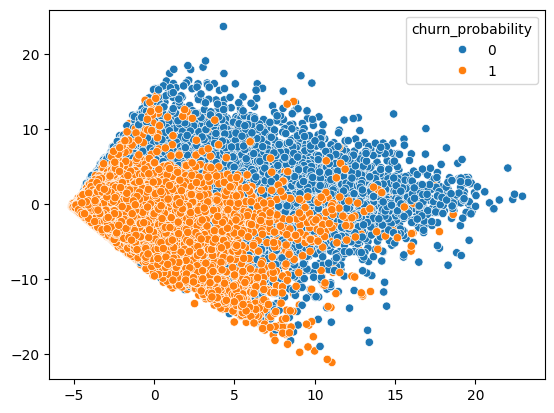

In [60]:
# Initialize PCA
pca = PCA()
pca_components = pca.fit_transform(X_train_model1)
#pca_components = pca.fit_transform(X_train_final_scaled)
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train_model1)
#sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y_train)
plt.show()

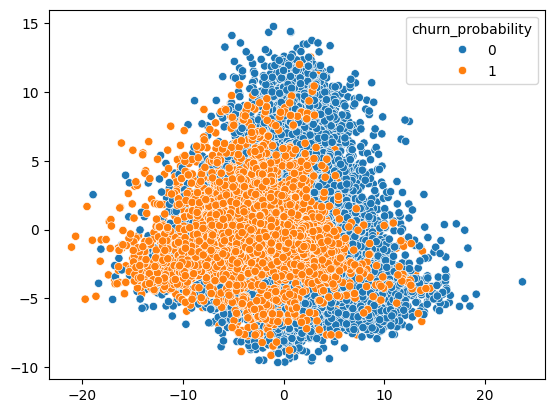

In [61]:
sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train_model1)
#sns.scatterplot(x=pca_components[:,1], y=pca_components[:,2], hue=y_train)
plt.show()

Since we have oversampled the "Churn" classes, we see a good representation of the same in the visualization in the first 3 PCA components

Lets see how many PCA components are able to explain more than 90% of variance in the model


In [62]:
pca.components_

array([[ 2.04412472e-01,  2.27159225e-01,  2.10393860e-01, ...,
         1.66810638e-02,  1.23211496e-03,  7.28645141e-03],
       [-1.25864287e-01, -2.47733640e-02,  1.41776644e-01, ...,
         1.63875312e-01,  3.84512583e-02,  5.24933936e-02],
       [ 1.92406080e-02, -4.70619419e-03, -1.83561049e-02, ...,
        -3.20444341e-02, -2.90091363e-02, -1.23550388e-02],
       ...,
       [ 0.00000000e+00, -2.60916273e-15,  2.40592085e-14, ...,
        -4.18045676e-02,  3.58518229e-02, -9.09656605e-03],
       [ 0.00000000e+00, -1.57515960e-15,  8.51206444e-15, ...,
        -1.51062897e-02,  5.02160418e-02,  4.17916580e-02],
       [-0.00000000e+00, -3.28779619e-16, -1.99081478e-14, ...,
        -9.03154514e-03, -2.20263157e-02, -1.20029665e-02]])

In [63]:
# Percentage of variances explained by the components
pca.explained_variance_ratio_

array([1.36919890e-01, 9.21777764e-02, 6.33208656e-02, 4.81918548e-02,
       4.01630472e-02, 3.33667777e-02, 3.12978425e-02, 2.77202992e-02,
       2.35707953e-02, 2.25684633e-02, 2.11602814e-02, 1.96583878e-02,
       1.89990831e-02, 1.83061169e-02, 1.66778590e-02, 1.61836621e-02,
       1.56945687e-02, 1.49728441e-02, 1.46129485e-02, 1.40868688e-02,
       1.35645066e-02, 1.32175287e-02, 1.28406257e-02, 1.23245171e-02,
       1.20525962e-02, 1.18996116e-02, 1.12139066e-02, 1.09513525e-02,
       1.06135282e-02, 1.00288305e-02, 9.78359479e-03, 9.43736518e-03,
       9.18791447e-03, 9.10383485e-03, 8.90277825e-03, 7.59428656e-03,
       7.25164771e-03, 7.09326133e-03, 6.29866898e-03, 6.10761931e-03,
       5.78317405e-03, 5.58955176e-03, 5.29710102e-03, 5.13277633e-03,
       4.98302186e-03, 4.91909868e-03, 4.66430793e-03, 4.60960451e-03,
       4.55090542e-03, 4.33187026e-03, 4.18742507e-03, 4.07056169e-03,
       3.67705308e-03, 3.55706052e-03, 3.48729903e-03, 3.33414270e-03,
      

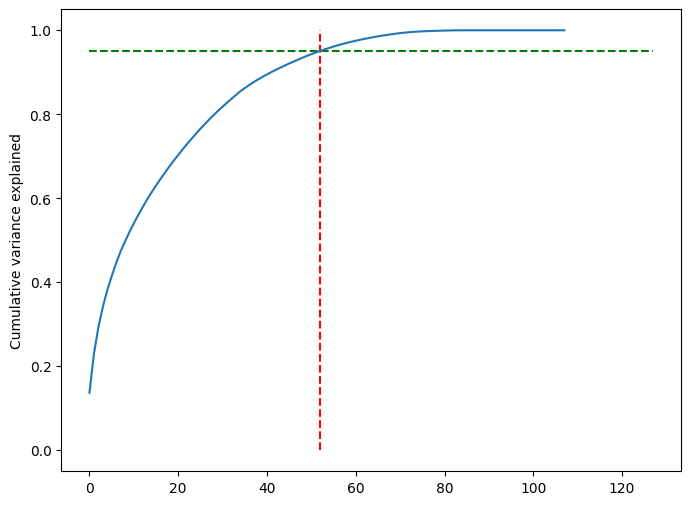

In [64]:
# Lets make a Scree plot for the explained variance
var_cumu = np.cumsum(pca.explained_variance_ratio_)
fig = plt.figure(figsize=[8,6])
plt.vlines(x=52, ymax=1, ymin=0, colors="r", linestyles="--")
plt.hlines(y=0.95, xmax=127, xmin=0, colors="g", linestyles="--")
plt.plot(var_cumu)
plt.ylabel("Cumulative variance explained")
plt.show()

Looks like around 50 components would be required to explain around 95% of the variance in the model

In [65]:
#Consider features contributing to 95% variance
pca2 = PCA(n_components=52)
pca_components2 = pca2.fit_transform(X_train_model1)

In [66]:
# Build a Logistics Regression Base Model on this PCA
# Model 1
logreg = LogisticRegression(random_state=55, max_iter=1000, tol=0.001, solver='sag')
lr_model = logreg.fit(pca_components2, y_train_model1)
# model1 = logreg.fit(pca_components2, y_train)

In [67]:
# Get accuracy score of this model
lr_model.score(pca_components2, y_train_model1)

0.8813463420601908

In [68]:
# Predict on train dataset
y_train_pca2_pred = lr_model.predict(pca_components2)

In [69]:
print(classification_report(y_train_model1, y_train_pca2_pred))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     50302
           1       0.77      0.69      0.73     15090

    accuracy                           0.88     65392
   macro avg       0.84      0.81      0.83     65392
weighted avg       0.88      0.88      0.88     65392



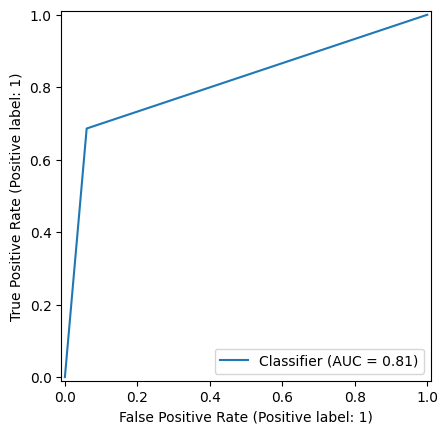

In [70]:
# Plot an ROC Curve
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_predictions(y_train_model1, y_train_pca2_pred)
plt.show()

In [71]:
# Plot the confusion matrix
confusion_matrix(y_train_model1, y_train_pca2_pred)

array([[47281,  3021],
       [ 4738, 10352]])

Lets use an ensemble technique like RandomForest to see if the scoring improves



In [72]:
len(pca2.components_)

52

Lets build an initial Ensemble model like Random forest on the original X_train dataset (108 features) to understand feature importances

In [73]:
# Model 2
rf = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=10, n_jobs=-1, oob_score=True)
rf_model1 = rf.fit(X_train_model1, y_train_model1)

In [74]:
# Lets see the Feature importances
feature_importances = pd.DataFrame({'col':final_columns, 'importance':rf.feature_importances_})
feature_importances.sort_values(by="importance", ascending=False)

col  importance
41            total_ic_mou_8    0.139155
32            total_og_mou_8    0.132943
35              loc_ic_mou_8    0.058397
56          total_rech_amt_8    0.051386
2                     arpu_8    0.046574
17              loc_og_mou_8    0.045857
62        last_day_rch_amt_8    0.039870
11             roam_ic_mou_8    0.028313
14             roam_og_mou_8    0.025745
38              std_ic_mou_8    0.025134
86                 arpu_diff    0.024136
5                onnet_mou_8    0.024135
8               offnet_mou_8    0.020948
34              loc_ic_mou_7    0.017779
102        total_ic_mou_diff    0.016775
85   days_from_last_recharge    0.016673
59            max_rech_amt_8    0.016118
90          roam_og_mou_diff    0.013672
104      total_rech_amt_diff    0.012376
96         total_og_mou_diff    0.011743
89          roam_ic_mou_diff    0.010924
40            total_ic_mou_7    0.010085
65               vol_2g_mb_8    0.009116
105        max_rech_amt_diff    0.008928
92           std_og_mou_diff    0.008887
53          total_rech_num_8    0.008321
31            total_og_mou_7    0.006959
97           loc_ic_mou_diff    0.006812
91           loc_og_mou_diff    0.006589
98           std_ic_mou_diff    0.006084
13             roam_og_mou_7    0.005272
81                       aon    0.005122
10             roam_ic_mou_7    0.004980
103      total_rech_num_diff    0.004794
88           offnet_mou_diff    0.004564
33              loc_ic_mou_6    0.004475
52          total_rech_num_7    0.004407
106           vol_2g_mb_diff    0.004380
68               vol_3g_mb_8    0.004141
16              loc_og_mou_7    0.003837
15              loc_og_mou_6    0.003785
39            total_ic_mou_6    0.003777
19              std_og_mou_7    0.003606
50               ic_others_8    0.003498
57            max_rech_amt_6    0.003318
1                     arpu_7    0.003264
107           vol_3g_mb_diff    0.002846
26              spl_og_mou_8    0.002832
87            onnet_mou_diff    0.002799
20              std_og_mou_8    0.002779
51          total_rech_num_6    0.002663
9              roam_ic_mou_6    0.002582
100          spl_ic_mou_diff    0.002564
18              std_og_mou_6    0.002521
58            max_rech_amt_7    0.002514
25              spl_og_mou_7    0.002475
61        last_day_rch_amt_7    0.002467
64               vol_2g_mb_7    0.002415
4                onnet_mou_7    0.002381
0                     arpu_6    0.002368
55          total_rech_amt_7    0.002247
94           spl_og_mou_diff    0.002110
7               offnet_mou_7    0.001916
60        last_day_rch_amt_6    0.001893
30            total_og_mou_6    0.001889
44              spl_ic_mou_8    0.001889
37              std_ic_mou_7    0.001854
6               offnet_mou_6    0.001838
101           ic_others_diff    0.001814
63               vol_2g_mb_6    0.001733
54          total_rech_amt_6    0.001696
3                onnet_mou_6    0.001666
12             roam_og_mou_6    0.001396
36              std_ic_mou_6    0.001357
82                aug_vbc_3g    0.001291
99           isd_ic_mou_diff    0.001277
24              spl_og_mou_6    0.001249
67               vol_3g_mb_7    0.001228
71              monthly_2g_8    0.001126
74               sachet_2g_8    0.001037
93           isd_og_mou_diff    0.000925
47              isd_ic_mou_8    0.000834
66               vol_3g_mb_6    0.000789
77              monthly_3g_8    0.000706
46              isd_ic_mou_7    0.000699
83                jul_vbc_3g    0.000689
73               sachet_2g_7    0.000657
45              isd_ic_mou_6    0.000613
21              isd_og_mou_6    0.000593
22              isd_og_mou_7    0.000589
23              isd_og_mou_8    0.000574
48               ic_others_6    0.000563
27               og_others_6    0.000554
84                jun_vbc_3g    0.000541
95            og_others_diff    0.000533
49               ic_others_7    0.000527
72               sachet_2g_6    0.000460
76     

<BarContainer object of 108 artists>

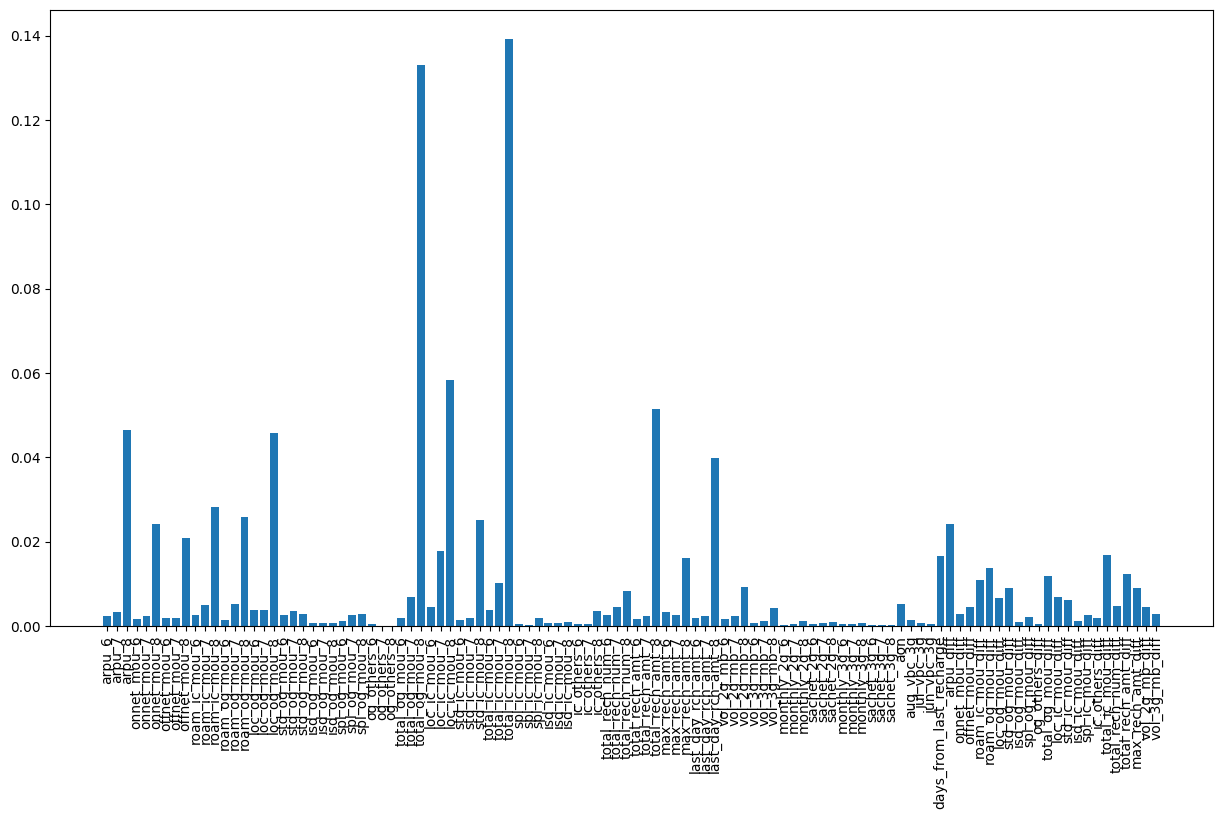

In [75]:
# Lets plot them
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.bar(feature_importances['col'], feature_importances['importance'])

In [76]:
y_train_rf_predict = rf_model1.predict(X_train_model1)
print(classification_report(y_train_model1, y_train_rf_predict))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     50302
           1       0.90      0.83      0.86     15090

    accuracy                           0.94     65392
   macro avg       0.93      0.90      0.91     65392
weighted avg       0.94      0.94      0.94     65392



In [77]:
# Build a random forest model with the PCA components

rf2 = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=7, n_jobs=-1, oob_score=True)
rf_model2 = rf2.fit(pca_components2, y_train_model1)

In [78]:
y_train_rf2_predict = rf_model2.predict(pca_components2)

In [79]:
print(classification_report(y_train_model1, y_train_rf2_predict))


              precision    recall  f1-score   support

           0       0.93      0.97      0.95     50302
           1       0.88      0.75      0.81     15090

    accuracy                           0.92     65392
   macro avg       0.91      0.86      0.88     65392
weighted avg       0.92      0.92      0.92     65392



In [80]:
# Tune the RandomForest with few selected Hyperparameters
# Model 3
rf_tuned = RandomForestClassifier(random_state=42, n_jobs=-1)
param_grid = {
    "criterion": ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20, 25],
    'n_estimators': [10, 30, 50, 100],
    'max_features' : [4, 7, 10]
}

folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_results = RandomizedSearchCV(estimator=rf_tuned, param_distributions=param_grid, cv=folds, n_jobs=-1, n_iter=10, scoring='accuracy', random_state=100)

In [81]:
%%time
cv_results.fit(pca_components2, y_train_model1)
# cv_results.fit(pca_components2, y_train)

CPU times: user 1min 11s, sys: 555 ms, total: 1min 11s
Wall time: 3min 35s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20, 25],
                                        'max_features': [4, 7, 10],
                                        'n_estimators': [10, 30, 50, 100]},
                   random_state=100, scoring='accuracy')

In [82]:
cv_results.best_estimator_

RandomForestClassifier(max_depth=20, max_features=10, n_estimators=50,
                       n_jobs=-1, random_state=42)

In [83]:
cv_results.best_params_

{'n_estimators': 50, 'max_features': 10, 'max_depth': 20, 'criterion': 'gini'}

In [84]:
rf_best = cv_results.best_estimator_

In [85]:
y_pred_rf_tuned = rf_best.predict(pca_components2)

In [86]:
print(classification_report(y_train_model1, y_pred_rf_tuned))
# print(classification_report(y_train, y_pred_rf_tuned))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     50302
           1       0.99      0.99      0.99     15090

    accuracy                           0.99     65392
   macro avg       0.99      0.99      0.99     65392
weighted avg       0.99      0.99      0.99     65392



Looks like the model overfit. Lets try it on the non-PCA features

In [87]:
%%time
cv_results.fit(X_train_model1, y_train_model1)

CPU times: user 35.8 s, sys: 219 ms, total: 36 s
Wall time: 1min 45s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
                   estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
                   n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [3, 5, 10, 20, 25],
                                        'max_features': [4, 7, 10],
                                        'n_estimators': [10, 30, 50, 100]},
                   random_state=100, scoring='accuracy')

In [88]:
cv_results.best_params_

{'n_estimators': 50,
 'max_features': 10,
 'max_depth': 20,
 'criterion': 'entropy'}

In [89]:
# Model 4
rf_best2 = cv_results.best_estimator_

In [90]:
y_pred_rf_tuned2 = rf_best2.predict(X_train_model1)
print(classification_report(y_train_model1, y_pred_rf_tuned2))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     50302
           1       0.98      1.00      0.99     15090

    accuracy                           0.99     65392
   macro avg       0.99      0.99      0.99     65392
weighted avg       0.99      0.99      0.99     65392



Lets perform a Hyperparameter Tuning for Logistic Regression using PCA

In [91]:
# Model 5
logreg2 = LogisticRegression(random_state=55, max_iter=1000, tol=0.001, solver='sag')

# create 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 4)

#hyperparameter tuning
params={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
        'penalty': ['l1', 'l2']
       }
cv_results_lr = RandomizedSearchCV(estimator=logreg2, param_distributions=params, cv=folds, n_jobs=-1, n_iter=30, scoring='accuracy', random_state=100)


In [92]:
%%time
cv_results_lr.fit(pca_components2, y_train_model1)

CPU times: user 1.31 s, sys: 67.7 ms, total: 1.38 s
Wall time: 9.72 s


RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=4, shuffle=True),
                   estimator=LogisticRegression(max_iter=1000, random_state=55,
                                                solver='sag', tol=0.001),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'C': [0.1, 0.5, 1, 2, 3, 4, 5, 10],
                                        'penalty': ['l1', 'l2']},
                   random_state=100, scoring='accuracy')

In [93]:
cv_results_lr.best_params_

{'penalty': 'l2', 'C': 1}

In [94]:
cv_results_lr.best_estimator_

LogisticRegression(C=1, max_iter=1000, random_state=55, solver='sag', tol=0.001)

In [95]:
lr_best = cv_results_lr.best_estimator_
y_pred_lr_tuned = lr_best.predict(pca_components2)
print(classification_report(y_train_model1, y_pred_lr_tuned))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     50302
           1       0.77      0.69      0.73     15090

    accuracy                           0.88     65392
   macro avg       0.84      0.81      0.83     65392
weighted avg       0.88      0.88      0.88     65392



Lets try another Ensemble model for boosting - XGBoostClassifier and train it on original non-PCA features to compare feature importances with RandomForestClassifier

In [96]:
from xgboost import XGBClassifier

# Model 6
xgb = XGBClassifier(objective='binary:logistic', scale_pos_weight=1, learning_rate=0.01, max_depth=10, reg_lambda=0.2, max_features=10)

In [97]:
xgb_model = xgb.fit(X_train_model1, y_train_model1)

In [98]:
y_train_xgb_predict = xgb_model.predict(X_train_model1)

In [99]:
print(classification_report(y_train_model1, y_train_xgb_predict))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97     50302
           1       0.93      0.84      0.88     15090

    accuracy                           0.95     65392
   macro avg       0.94      0.91      0.93     65392
weighted avg       0.95      0.95      0.95     65392



In [100]:
# Lets see the Feature importances
feature_importances_xgb = pd.DataFrame({'col':final_columns, 'importance':xgb.feature_importances_})
feature_importances_xgb.sort_values(by="importance", ascending=False)

col  importance
41            total_ic_mou_8    0.421141
14             roam_og_mou_8    0.091087
65               vol_2g_mb_8    0.028790
62        last_day_rch_amt_8    0.020186
56          total_rech_amt_8    0.019592
85   days_from_last_recharge    0.012963
44              spl_ic_mou_8    0.012784
32            total_og_mou_8    0.012393
35              loc_ic_mou_8    0.012239
19              std_og_mou_7    0.011529
68               vol_3g_mb_8    0.009721
22              isd_og_mou_7    0.008277
11             roam_ic_mou_8    0.008034
102        total_ic_mou_diff    0.007404
59            max_rech_amt_8    0.007253
23              isd_og_mou_8    0.006364
86                 arpu_diff    0.006116
53          total_rech_num_8    0.005979
33              loc_ic_mou_6    0.005624
96         total_og_mou_diff    0.005468
61        last_day_rch_amt_7    0.005300
50               ic_others_8    0.005267
39            total_ic_mou_6    0.005174
40            total_ic_mou_7    0.005153
57            max_rech_amt_6    0.004919
52          total_rech_num_7    0.004865
2                     arpu_8    0.004861
74               sachet_2g_8    0.004794
104      total_rech_amt_diff    0.004640
47              isd_ic_mou_8    0.004569
51          total_rech_num_6    0.004512
90          roam_og_mou_diff    0.004456
13             roam_og_mou_7    0.004399
98           std_ic_mou_diff    0.004356
81                       aon    0.004192
107           vol_3g_mb_diff    0.004051
10             roam_ic_mou_7    0.004015
77              monthly_3g_8    0.004001
30            total_og_mou_6    0.003879
37              std_ic_mou_7    0.003863
79               sachet_3g_7    0.003837
55          total_rech_amt_7    0.003818
25              spl_og_mou_7    0.003811
92           std_og_mou_diff    0.003799
103      total_rech_num_diff    0.003728
46              isd_ic_mou_7    0.003727
100          spl_ic_mou_diff    0.003726
89          roam_ic_mou_diff    0.003711
49               ic_others_7    0.003591
70              monthly_2g_7    0.003565
31            total_og_mou_7    0.003522
60        last_day_rch_amt_6    0.003520
72               sachet_2g_6    0.003511
73               sachet_2g_7    0.003464
38              std_ic_mou_8    0.003420
58            max_rech_amt_7    0.003356
101           ic_others_diff    0.003338
12             roam_og_mou_6    0.003280
97           loc_ic_mou_diff    0.003274
17              loc_og_mou_8    0.003258
27               og_others_6    0.003255
93           isd_og_mou_diff    0.003242
15              loc_og_mou_6    0.003210
78               sachet_3g_6    0.003206
71              monthly_2g_8    0.003205
82                aug_vbc_3g    0.003184
21              isd_og_mou_6    0.003182
7               offnet_mou_7    0.003155
6               offnet_mou_6    0.003141
9              roam_ic_mou_6    0.003112
18              std_og_mou_6    0.003105
3                onnet_mou_6    0.003065
106           vol_2g_mb_diff    0.003053
99           isd_ic_mou_diff    0.003004
54          total_rech_amt_6    0.002975
20              std_og_mou_8    0.002972
45              isd_ic_mou_6    0.002959
88           offnet_mou_diff    0.002904
34              loc_ic_mou_7    0.002895
1                     arpu_7    0.002866
94           spl_og_mou_diff    0.002851
4                onnet_mou_7    0.002844
24              spl_og_mou_6    0.002841
67               vol_3g_mb_7    0.002833
5                onnet_mou_8    0.002820
42              spl_ic_mou_6    0.002813
91           loc_og_mou_diff    0.002764
95            og_others_diff    0.002754
36              std_ic_mou_6    0.002690
87            onnet_mou_diff    0.002608
105        max_rech_amt_diff    0.002520
16              loc_og_mou_7    0.002478
8               offnet_mou_8    0.002456
26              spl_og_mou_8    0.002453
48               ic_others_6    0.002418
63               vol_2g_mb_6    0.002400
84                jun_vbc_3g    0.002393
0      

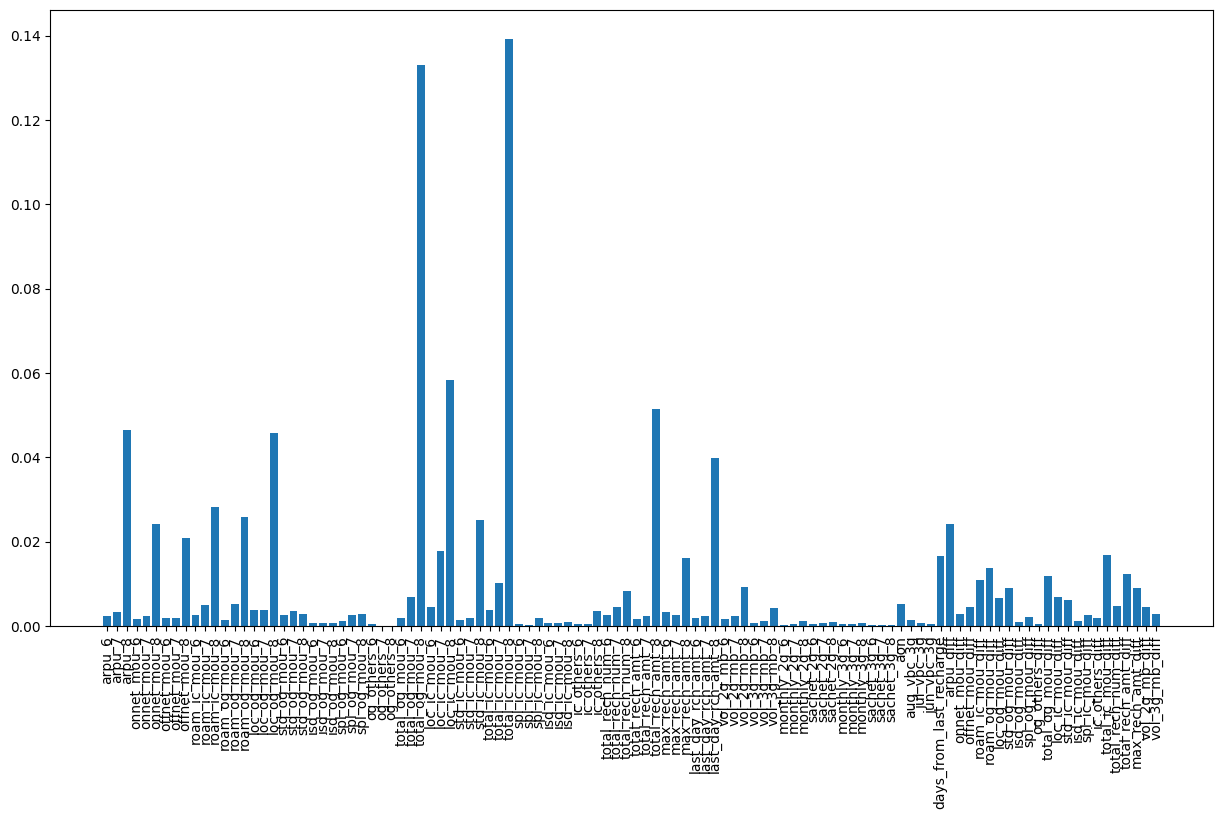

In [101]:
# Lets plot them
plt.figure(figsize=(15,8))
plt.xticks(rotation=90)
plt.bar(feature_importances_xgb['col'], feature_importances['importance'])
plt.show()

Lets create a model with the top 30 features using the RandomForestClassifier Model 1 and XGBoostClassifier which performed the best amongs all the models so far with a good balance of accuracy, recall and precision. We will not use the PCA components for this, but the original top 30 features by importance

In [102]:
# extract top 'n' features

top_features = feature_importances.sort_values(by="importance", ascending=False)
top_features = top_features.reset_index().loc[:29, 'col']
top_features

0              total_ic_mou_8
1              total_og_mou_8
2                loc_ic_mou_8
3            total_rech_amt_8
4                      arpu_8
5                loc_og_mou_8
6          last_day_rch_amt_8
7               roam_ic_mou_8
8               roam_og_mou_8
9                std_ic_mou_8
10                  arpu_diff
11                onnet_mou_8
12               offnet_mou_8
13               loc_ic_mou_7
14          total_ic_mou_diff
15    days_from_last_recharge
16             max_rech_amt_8
17           roam_og_mou_diff
18        total_rech_amt_diff
19          total_og_mou_diff
20           roam_ic_mou_diff
21             total_ic_mou_7
22                vol_2g_mb_8
23          max_rech_amt_diff
24            std_og_mou_diff
25           total_rech_num_8
26             total_og_mou_7
27            loc_ic_mou_diff
28            loc_og_mou_diff
29            std_ic_mou_diff
Name: col, dtype: object

In [103]:
X_train_model1_df = pd.DataFrame(X_train_model1, columns=final_columns)
X_train_model1_df.head()

arpu_6    arpu_7    arpu_8  onnet_mou_6  onnet_mou_7  onnet_mou_8  \
0 -0.975144 -0.266106 -0.976388    -0.549501    -0.391829    -0.498713   
1 -0.080113  0.240209  1.632789     1.202208     2.259132     4.402029   
2 -0.260855  0.101340  0.482602    -0.399734    -0.363915    -0.192178   
3 -0.739685 -0.614007 -0.697796    -0.377991    -0.328435    -0.268600   
4 -0.313463 -0.348553 -0.466124    -0.284852    -0.170412    -0.125273   

   offnet_mou_6  offnet_mou_7  offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  \
0     -0.667452     -0.129979     -0.722497      -0.258283      -0.217787   
1     -0.315762     -0.254483      0.145713      -0.258283      -0.217787   
2      0.135900      0.079201      0.243871      -0.258283      -0.217787   
3     -0.472401     -0.380398     -0.513146      -0.258283      -0.217787   
4     -0.102411     -0.199872     -0.404426      -0.258283      -0.217787   

   roam_ic_mou_8  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_mou_6  \
0      -0.221631       -0.27852      -0.249187      -0.244744     -0.602630   
1      -0.221631       -0.27852      -0.249187      -0.244744     -0.636062   
2      -0.221631       -0.27852      -0.249187      -0.244744     -0.068498   
3      -0.221631       -0.27852      -0.249187      -0.244744     -0.148867   
4      -0.221631       -0.27852      -0.249187      -0.244744      0.442388   

   loc_og_mou_7  loc_og_mou_8  std_og_mou_6  std_og_mou_7  std_og_mou_8  \
0      0.284350     -0.657508     -0.500081     -0.498686     -0.493131   
1     -0.510315     -0.532039      1.049134      1.671930      4.029858   
2      0.012772      0.111342     -0.072969     -0.158391      0.005469   
3      0.021848     -0.097602     -0.500081     -0.498686     -0.493131   
4      0.232604      0.200145     -0.498035     -0.367468     -0.483009   

   isd_og_mou_6  isd_og_mou_7  isd_og_mou_8  spl_og_mou_6  spl_og_mou_7  \
0     -0.089034      0.775942     -0.085453     -0.403854     -0.409325   
1     -0.089034     -0.089691      0.020405     -0.175799      1.387754   
2     -0.089034     -0.089691     -0.085453     -0.384130     -0.409325   
3     -0.089034     -0.089691     -0.085453     -0.381664     -0.409325   
4     -0.089034     -0.089691     -0.085453     -0.403854     -0.409325   

   spl_og_mou_8  og_others_6  og_others_7  og_others_8  total_og_mou_6  \
0     -0.439349    -0.293078    -0.040553    -0.041751       -0.716033   
1     -0.119728    -0.293078    -0.040553    -0.041751        0.477627   
2      0.534281    -0.293078    -0.040553    -0.041751       -0.127453   
3     -0.439349    -0.293078    -0.040553    -0.041751       -0.498087   
4     -0.223104    -0.293078    -0.040553    -0.041751       -0.213612   

   total_og_mou_7  total_og_mou_8  loc_ic_mou_6  loc_ic_mou_7  loc_ic_mou_8  \
0       -0.291796       -0.728956     -0.805620     -0.560289     -0.798746   
1        1.099290        3.783098     -0.734276     -0.596607     -0.670050   
2       -0.157530        0.042236     -0.586515     -0.395733     -0.508439   
3       -0.422689       -0.471231     -0.366876     -0.255925     -0.304557   
4       -0.222591       -0.320848     -0.039954     -0.203913     -0.051951   

   std_ic_mou_6  std_ic_mou_7  std_ic_mou_8  total_ic_mou_6  total_ic_mou_7  \
0     -0.473777     -0.468883     -0.468484       -0.847665       -0.641670   
1     -0.312203     -0.207145      0.070882       -0.741150       -0.599553   
2     -0.382646     -0.207650     -0.219774       -0.612577       -0.406962   
3     -0.473777     -0.468883     -0.468484       -0.478569       -0.389236   
4     -0.295617      0.059975     -0.353829       -0.158620       -0.192869   

   total_ic_mou_8  spl_ic_mou_6  spl_ic_mou_7  spl_ic_mou_8  isd_ic_mou_6  \
0       -0.840127     -0.426849     -0.298547     -0.316231     -0.215008   
1       -0.593790     -0.426849     -0.298547     -0.316231     -0.215008   
2       -0.494743     -0.426849     -0.298547      2.058791     -0.215008   
3       -0.427740

In [104]:
# Refine the X_train and limit it to these 30 features
X_train_refined = X_train_model1_df[top_features]
X_train_refined.head()

total_ic_mou_8  total_og_mou_8  loc_ic_mou_8  total_rech_amt_8    arpu_8  \
0       -0.840127       -0.728956     -0.798746         -0.968902 -0.976388   
1       -0.593790        3.783098     -0.670050          1.539665  1.632789   
2       -0.494743        0.042236     -0.508439          0.515949  0.482602   
3       -0.427740       -0.471231     -0.304557         -0.569253 -0.697796   
4       -0.187461       -0.320848     -0.051951         -0.169603 -0.466124   

   loc_og_mou_8  last_day_rch_amt_8  roam_ic_mou_8  roam_og_mou_8  \
0     -0.657508           -0.769076      -0.221631      -0.244744   
1     -0.532039            0.922643      -0.221631      -0.244744   
2      0.111342            0.922643      -0.221631      -0.244744   
3     -0.097602            0.922643      -0.221631      -0.244744   
4      0.200145            0.922643      -0.221631      -0.244744   

   std_ic_mou_8  arpu_diff  onnet_mou_8  offnet_mou_8  loc_ic_mou_7  \
0     -0.468484  -0.508323    -0.498713     -0.722497     -0.560289   
1      0.070882   2.136325     4.402029      0.145713     -0.596607   
2     -0.219774   0.769949    -0.192178      0.243871     -0.395733   
3     -0.468484  -0.047376    -0.268600     -0.513146     -0.255925   
4     -0.353829  -0.194553    -0.125273     -0.404426     -0.203913   

   total_ic_mou_diff  days_from_last_recharge  max_rech_amt_8  \
0          -0.153204                -0.193382       -1.079765   
1           0.131041                -0.551438        0.279870   
2           0.027757                -0.193382        0.792347   
3           0.013060                 0.284026        0.279870   
4          -0.017891                -0.790142        0.279870   

   roam_og_mou_diff  total_rech_amt_diff  total_og_mou_diff  roam_ic_mou_diff  \
0          0.066571            -0.263674          -0.318291          0.057379   
1          0.066571             1.781199           4.156369          0.057379   
2          0.066571             0.663442           0.256640          0.057379   
3          0.066571             0.083493          -0.016953          0.057379   
4          0.066571             0.123628          -0.143193          0.057379   

   total_ic_mou_7  vol_2g_mb_8  max_rech_amt_diff  std_og_mou_diff  \
0       -0.641670    -0.309029          -0.668691         0.004049   
1       -0.599553    -0.309029           0.210938         3.803597   
2       -0.406962    -0.246961           0.393147         0.172812   
3       -0.389236    -0.309029           0.210938         0.004049   
4       -0.192869    -0.309029           0.210938        -0.077930   

   total_rech_num_8  total_og_mou_7  loc_ic_mou_diff  loc_og_mou_diff  \
0         -0.812191       -0.291796        -0.195314        -0.862830   
1          0.159430        1.099290        -0.001411         0.087885   
2         -0.002506       -0.157530        -0.025226         0.245525   
3         -0.812191       -0.422689         0.015124        -0.056785   
4         -0.164443       -0.222591         0.123208        -0.251252   

   std_ic_mou_diff  
0         0.010349  
1         0.471872  
2         0.107630  
3         0.010349  
4        -0.341827

In [105]:
# Build the model

rf3 = RandomForestClassifier(n_estimators=50, max_depth=10, max_features=10, n_jobs=-1, oob_score=True)

# Convert df to array
X_train_refined_array = np.array(X_train_refined)
rf_model3 = rf3.fit(X_train_refined_array, y_train_model1)

In [106]:
y_train_rf3_pred = rf_model3.predict(X_train_refined_array)
print(classification_report(y_train_model1, y_train_rf3_pred))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96     50302
           1       0.90      0.85      0.87     15090

    accuracy                           0.94     65392
   macro avg       0.93      0.91      0.92     65392
weighted avg       0.94      0.94      0.94     65392



## Test data preparation

In [107]:
X_test.head()

loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou last_date_of_month_6  \
id                                                                           
16754             0.0             0.0             0.0            6/30/2014   
52758             0.0             0.0             0.0            6/30/2014   
11019             0.0             0.0             0.0            6/30/2014   
4679              0.0             0.0             0.0            6/30/2014   
1158              0.0             0.0             0.0            6/30/2014   

      last_date_of_month_7 last_date_of_month_8   arpu_6   arpu_7   arpu_8  \
id                                                                           
16754            7/31/2014            8/31/2014  265.803  204.091  520.079   
52758            7/31/2014            8/31/2014  328.087  191.523  261.933   
11019            7/31/2014            8/31/2014  239.518   31.260    0.010   
4679             7/31/2014            8/31/2014  305.177   73.328   60.321   
1158             7/31/2014            8/31/2014  130.347    0.000  891.310   

       onnet_mou_6  onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                                                                         
16754       187.36       204.29       254.69        291.28        165.61   
52758        32.26         2.01        12.68         83.74          6.51   
11019       110.94         9.53         0.00        181.98         21.46   
4679        162.73        39.74         2.78        129.59         35.19   
1158          4.01          NaN        80.88        132.99           NaN   

       offnet_mou_8  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
id                                                                 
16754        977.33            0.0            0.0            0.0   
52758         39.08            0.0            0.0            0.0   
11019          0.00            0.0            0.0            0.0   
4679          54.48            0.0            0.0            0.0   
1158         484.81            0.0            NaN            0.0   

       roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  loc_og_t2t_mou_6  \
id                                                                     
16754           0.00            0.0            0.0              8.41   
52758           0.00            0.0            0.0             32.26   
11019           6.83            0.0            0.0             36.94   
4679            0.00            0.0            0.0              0.30   
1158            0.00            NaN            0.0              4.01   

       loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2m_mou_6  loc_og_t2m_mou_7  \
id                                                                              
16754              8.56              3.89             29.53             17.44   
52758              2.01             12.68             78.74              6.51   
11019              0.00              0.00             93.14              0.00   
4679               2.68              2.78             35.63             10.94   
1158                NaN             40.98            121.06               NaN   

       loc_og_t2m_mou_8  loc_og_t2f_mou_6  loc_og_t2f_mou_7  loc_og_t2f_mou_8  \
id                                                                              
16754             43.49             30.78              0.53              0.00   
52758             32.29              1.38              0.00              2.45   
11019              0.00              0.00              0.00              0.00   
4679              30.58             11.09              0.54              3.69   
1158             376.88             11.93               NaN             81.68   

       loc_og_t2c_mou_6  loc_og_t2c_mou_7  loc_og_t2c_mou_8  loc_og_mou_6  \
id                                                                          
16754              7.94              7.98              5.25         68.73   
52758              0.00        

In [108]:
X_test.shape

(14000, 169)

In [109]:
# Data Manipulation for X_test dataset in same order as we have done for X_train

X_test_filtered = X_test[new_vars]
X_test_filtered.drop(nonunique_features, axis=1, inplace=True)
X_test_filtered[rech_cols] = X_test_filtered[rech_cols].apply(lambda x: x.fillna(0))
day_counts(X_test_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')
X_test_filtered[['days_from_last_recharge']] = X_test_filtered[['days_from_last_recharge']].fillna(-1)

# In case of imputation only apply the transform() method to apply value learned during training
X_test_filtered[impute_cols] = imp.transform(X_test_filtered[impute_cols])

# Process and cap outliers for test data
X_test_filtered = X_test_filtered.apply(cap_outliers, axis=0)

# Feature engineering for test dataset
X_test_filtered['arpu_diff'] = X_test_filtered.arpu_8 - ((X_test_filtered.arpu_6 + X_test_filtered.arpu_7)/2)

X_test_filtered['onnet_mou_diff'] = X_test_filtered.onnet_mou_8 - ((X_test_filtered.onnet_mou_6 + X_test_filtered.onnet_mou_7)/2)

X_test_filtered['offnet_mou_diff'] = X_test_filtered.offnet_mou_8 - ((X_test_filtered.offnet_mou_6 + X_test_filtered.offnet_mou_7)/2)

X_test_filtered['roam_ic_mou_diff'] = X_test_filtered.roam_ic_mou_8 - ((X_test_filtered.roam_ic_mou_6 + X_test_filtered.roam_ic_mou_7)/2)

X_test_filtered['roam_og_mou_diff'] = X_test_filtered.roam_og_mou_8 - ((X_test_filtered.roam_og_mou_6 + X_test_filtered.roam_og_mou_7)/2)

X_test_filtered['loc_og_mou_diff'] = X_test_filtered.loc_og_mou_8 - ((X_test_filtered.loc_og_mou_6 + X_test_filtered.loc_og_mou_7)/2)

X_test_filtered['std_og_mou_diff'] = X_test_filtered.std_og_mou_8 - ((X_test_filtered.std_og_mou_6 + X_test_filtered.std_og_mou_7)/2)

X_test_filtered['isd_og_mou_diff'] = X_test_filtered.isd_og_mou_8 - ((X_test_filtered.isd_og_mou_6 + X_test_filtered.isd_og_mou_7)/2)

X_test_filtered['spl_og_mou_diff'] = X_test_filtered.spl_og_mou_8 - ((X_test_filtered.spl_og_mou_6 + X_test_filtered.spl_og_mou_7)/2)

X_test_filtered['og_others_diff'] = X_test_filtered.og_others_8 - ((X_test_filtered.og_others_6 + X_test_filtered.og_others_7)/2)

X_test_filtered['total_og_mou_diff'] = X_test_filtered.total_og_mou_8 - ((X_test_filtered.total_og_mou_6 + X_test_filtered.total_og_mou_7)/2)

X_test_filtered['loc_ic_mou_diff'] = X_test_filtered.loc_ic_mou_8 - ((X_test_filtered.loc_ic_mou_6 + X_test_filtered.loc_ic_mou_7)/2)

X_test_filtered['std_ic_mou_diff'] = X_test_filtered.std_ic_mou_8 - ((X_test_filtered.std_ic_mou_6 + X_test_filtered.std_ic_mou_7)/2)

X_test_filtered['isd_ic_mou_diff'] = X_test_filtered.isd_ic_mou_8 - ((X_test_filtered.isd_ic_mou_6 + X_test_filtered.isd_ic_mou_7)/2)

X_test_filtered['spl_ic_mou_diff'] = X_test_filtered.spl_ic_mou_8 - ((X_test_filtered.spl_ic_mou_6 + X_test_filtered.spl_ic_mou_7)/2)

X_test_filtered['ic_others_diff'] = X_test_filtered.ic_others_8 - ((X_test_filtered.ic_others_6 + X_test_filtered.ic_others_7)/2)

X_test_filtered['total_ic_mou_diff'] = X_test_filtered.total_ic_mou_8 - ((X_test_filtered.total_ic_mou_6 + X_test_filtered.total_ic_mou_7)/2)

X_test_filtered['total_rech_num_diff'] = X_test_filtered.total_rech_num_8 - ((X_test_filtered.total_rech_num_6 + X_test_filtered.total_rech_num_7)/2)

X_test_filtered['total_rech_amt_diff'] = X_test_filtered.total_rech_amt_8 - ((X_test_filtered.total_rech_amt_6 + X_test_filtered.total_rech_amt_7)/2)

X_test_filtered['max_rech_amt_diff'] = X_test_filtered.max_rech_amt_8 - ((X_test_filtered.max_rech_amt_6 + X_test_filtered.max_rech_amt_7)/2)

X_test_filtered['vol_2g_mb_diff'] = X_test_filtered.vol_2g_mb_8 - ((X_test_filtered.vol_2g_mb_6 + X_test_filtered.vol_2g_mb_7)/2)

X_test_filtered['vol_3g_mb_diff'] = X_test_filtered.vol_3g_mb_8 - ((X_test_filtered.vol_3g_mb_6 + X_test_filtered.vol_3g_mb_7)/2)

X_test_filtered.drop(columns_to_del, axis=1, inplace = True)

# Perform scaling for test dataset and again apply only transform method

X_test_final_scaled = scale.transform(X_test_filtered)

# Create test PCA components by using the transform method

test_pca_components = pca2.transform(X_test_final_scaled)



Start Model Prediction for X_test dataset

In [110]:
# Start with the Model 1 the first LogisticRegression model with PCA components(52)

y_test_lr1_pred = lr_model.predict(test_pca_components)
print(classification_report(y_test, y_test_lr1_pred))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12565
           1       0.55      0.66      0.60      1435

    accuracy                           0.91     14000
   macro avg       0.76      0.80      0.77     14000
weighted avg       0.92      0.91      0.91     14000



In [111]:
# Next predict based on RandomForest model that was trained on non-PCA original 108 features

y_test_rf_pred = rf_model1.predict(X_test_final_scaled)
print(classification_report(y_test, y_test_rf_pred))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12565
           1       0.71      0.70      0.70      1435

    accuracy                           0.94     14000
   macro avg       0.84      0.83      0.83     14000
weighted avg       0.94      0.94      0.94     14000



In [112]:
# Next predict based on RandomForest model that was trained on PCA components (52)

y_test_rf2_pred = rf_model2.predict(test_pca_components)
print(classification_report(y_test, y_test_rf2_pred))


              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12565
           1       0.61      0.54      0.57      1435

    accuracy                           0.92     14000
   macro avg       0.78      0.75      0.76     14000
weighted avg       0.91      0.92      0.91     14000



In [113]:
# Next predict based on the Hyperparameter tuned RandomForest model that was trained on PCA components (52)

y_test_rf3_pred = rf_best.predict(test_pca_components)
print(classification_report(y_test, y_test_rf3_pred))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     12565
           1       0.60      0.55      0.58      1435

    accuracy                           0.92     14000
   macro avg       0.78      0.76      0.77     14000
weighted avg       0.91      0.92      0.92     14000



In [114]:
# Next set predict based on the tuned Logistic Regression model with PCA components (52)

y_test_lr_tuned = lr_best.predict(test_pca_components)
print(classification_report(y_test, y_test_lr_tuned))

              precision    recall  f1-score   support

           0       0.96      0.94      0.95     12565
           1       0.55      0.66      0.60      1435

    accuracy                           0.91     14000
   macro avg       0.76      0.80      0.77     14000
weighted avg       0.92      0.91      0.91     14000



In [115]:
# Next predict based on the Ensemble model using XGBoostClassifier on the original non-PCA features (108)

y_test_xgb = xgb_model.predict(X_test_final_scaled)
print(classification_report(y_test, y_test_xgb))

              precision    recall  f1-score   support

           0       0.96      0.97      0.97     12565
           1       0.73      0.65      0.69      1435

    accuracy                           0.94     14000
   macro avg       0.85      0.81      0.83     14000
weighted avg       0.94      0.94      0.94     14000



In [116]:
# Next predict based on the Ensemble model using RandomForestClassifier on the top 30 non-PCA features

# Refine the X_train and limit it to these 30 features
X_test_top_30_df = pd.DataFrame(X_test_final_scaled, columns=final_columns)
X_test_refined = X_test_top_30_df[top_features]
X_test_refined_array = np.array(X_test_refined)
y_test_rf4_pred = rf_model3.predict(X_test_refined_array)
print(classification_report(y_test, y_test_rf4_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96     12565
           1       0.68      0.71      0.70      1435

    accuracy                           0.94     14000
   macro avg       0.82      0.84      0.83     14000
weighted avg       0.94      0.94      0.94     14000



## Unseen data processing, model prediction and submission to Kaggle

In [117]:
submission = unseen.set_index("id")

In [118]:
submission_filtered = submission[new_vars]

In [119]:
# Data Manipulation for unseen dataset in same order as we have done for X_train

submission_filtered = submission[new_vars]
submission_filtered.drop(nonunique_features, axis=1, inplace=True)
submission_filtered[rech_cols] = submission_filtered[rech_cols].apply(lambda x: x.fillna(0))
day_counts(submission_filtered, date_of_last_rech, date_beyond_dataset, 'days_from_last_recharge')
submission_filtered[['days_from_last_recharge']] = submission_filtered[['days_from_last_recharge']].fillna(-1)

# In case of imputation only apply the transform() method to apply value learned during training
submission_filtered[impute_cols] = imp.transform(submission_filtered[impute_cols])

# Process and cap outliers for unseen test data
submission_filtered = submission_filtered.apply(cap_outliers, axis=0)

# Feature engineering for unseen test dataset
submission_filtered['arpu_diff'] = submission_filtered.arpu_8 - ((submission_filtered.arpu_6 + submission_filtered.arpu_7)/2)

submission_filtered['onnet_mou_diff'] = submission_filtered.onnet_mou_8 - ((submission_filtered.onnet_mou_6 + submission_filtered.onnet_mou_7)/2)

submission_filtered['offnet_mou_diff'] = submission_filtered.offnet_mou_8 - ((submission_filtered.offnet_mou_6 + submission_filtered.offnet_mou_7)/2)

submission_filtered['roam_ic_mou_diff'] = submission_filtered.roam_ic_mou_8 - ((submission_filtered.roam_ic_mou_6 + submission_filtered.roam_ic_mou_7)/2)

submission_filtered['roam_og_mou_diff'] = submission_filtered.roam_og_mou_8 - ((submission_filtered.roam_og_mou_6 + submission_filtered.roam_og_mou_7)/2)

submission_filtered['loc_og_mou_diff'] = submission_filtered.loc_og_mou_8 - ((submission_filtered.loc_og_mou_6 + submission_filtered.loc_og_mou_7)/2)

submission_filtered['std_og_mou_diff'] = submission_filtered.std_og_mou_8 - ((submission_filtered.std_og_mou_6 + submission_filtered.std_og_mou_7)/2)

submission_filtered['isd_og_mou_diff'] = submission_filtered.isd_og_mou_8 - ((submission_filtered.isd_og_mou_6 + submission_filtered.isd_og_mou_7)/2)

submission_filtered['spl_og_mou_diff'] = submission_filtered.spl_og_mou_8 - ((submission_filtered.spl_og_mou_6 + submission_filtered.spl_og_mou_7)/2)

submission_filtered['og_others_diff'] = submission_filtered.og_others_8 - ((submission_filtered.og_others_6 + submission_filtered.og_others_7)/2)

submission_filtered['total_og_mou_diff'] = submission_filtered.total_og_mou_8 - ((submission_filtered.total_og_mou_6 + submission_filtered.total_og_mou_7)/2)

submission_filtered['loc_ic_mou_diff'] = submission_filtered.loc_ic_mou_8 - ((submission_filtered.loc_ic_mou_6 + submission_filtered.loc_ic_mou_7)/2)

submission_filtered['std_ic_mou_diff'] = submission_filtered.std_ic_mou_8 - ((submission_filtered.std_ic_mou_6 + submission_filtered.std_ic_mou_7)/2)

submission_filtered['isd_ic_mou_diff'] = submission_filtered.isd_ic_mou_8 - ((submission_filtered.isd_ic_mou_6 + submission_filtered.isd_ic_mou_7)/2)

submission_filtered['spl_ic_mou_diff'] = submission_filtered.spl_ic_mou_8 - ((submission_filtered.spl_ic_mou_6 + submission_filtered.spl_ic_mou_7)/2)

submission_filtered['ic_others_diff'] = submission_filtered.ic_others_8 - ((submission_filtered.ic_others_6 + submission_filtered.ic_others_7)/2)

submission_filtered['total_ic_mou_diff'] = submission_filtered.total_ic_mou_8 - ((submission_filtered.total_ic_mou_6 + submission_filtered.total_ic_mou_7)/2)

submission_filtered['total_rech_num_diff'] = submission_filtered.total_rech_num_8 - ((submission_filtered.total_rech_num_6 + submission_filtered.total_rech_num_7)/2)

submission_filtered['total_rech_amt_diff'] = submission_filtered.total_rech_amt_8 - ((submission_filtered.total_rech_amt_6 + submission_filtered.total_rech_amt_7)/2)

submission_filtered['max_rech_amt_diff'] = submission_filtered.max_rech_amt_8 - ((submission_filtered.max_rech_amt_6 + submission_filtered.max_rech_amt_7)/2)

submission_filtered['vol_2g_mb_diff'] = submission_filtered.vol_2g_mb_8 - ((submission_filtered.vol_2g_mb_6 + submission_filtered.vol_2g_mb_7)/2)

submission_filtered['vol_3g_mb_diff'] = submission_filtered.vol_3g_mb_8 - ((submission_filtered.vol_3g_mb_6 + submission_filtered.vol_3g_mb_7)/2)

submission_filtered.drop(columns_to_del, axis=1, inplace = True)

# Perform scaling for unseen test dataset and again apply only transform method
submission_final_scaled = scale.transform(submission_filtered)

# Create test PCA components by using the transform method
submission_pca_components = pca2.fit_transform(submission_final_scaled)

In [ ]:
# Predict based on the best model so far using RandomForest model that was trained on non-PCA original 108 features

#unseen['churn_probability'] = rf_model1.predict(submission_final_scaled)

In [ ]:
# output = unseen[['id','churn_probability']]
# output.head()

In [ ]:
#output.to_csv('submission_13Jan25_1.csv',index=False)

In [121]:
# submission_top_30_df = pd.DataFrame(submission_final_scaled, columns=final_columns)
# submission_refined = submission_top_30_df[top_features]
# submission_refined_array = np.array(submission_refined)


In [125]:
unseen['churn_probability'] = xgb_model.predict(submission_final_scaled)

In [126]:
output = unseen[['id','churn_probability']]
output.head()

id  churn_probability
0  69999                  0
1  70000                  0
2  70001                  1
3  70002                  0
4  70003                  0

In [127]:
output.to_csv('submission_13Jan25_3.csv',index=False)